## Machine Learning Project: American Express Credit Card Default Risk Prediction

### 1. Problem formulation

**Background**: Credit Card Default Risk Prediction is very commonly used in many world-wide banks and financial institutions. It can help these financial institutions to idendify customers who may have difficulty repaying their debts in the future. By reducing the risk of lending the money to such customers, these institutions can save a lot of money on credit card charge-offs as well as ensure the stability of their financial systems.

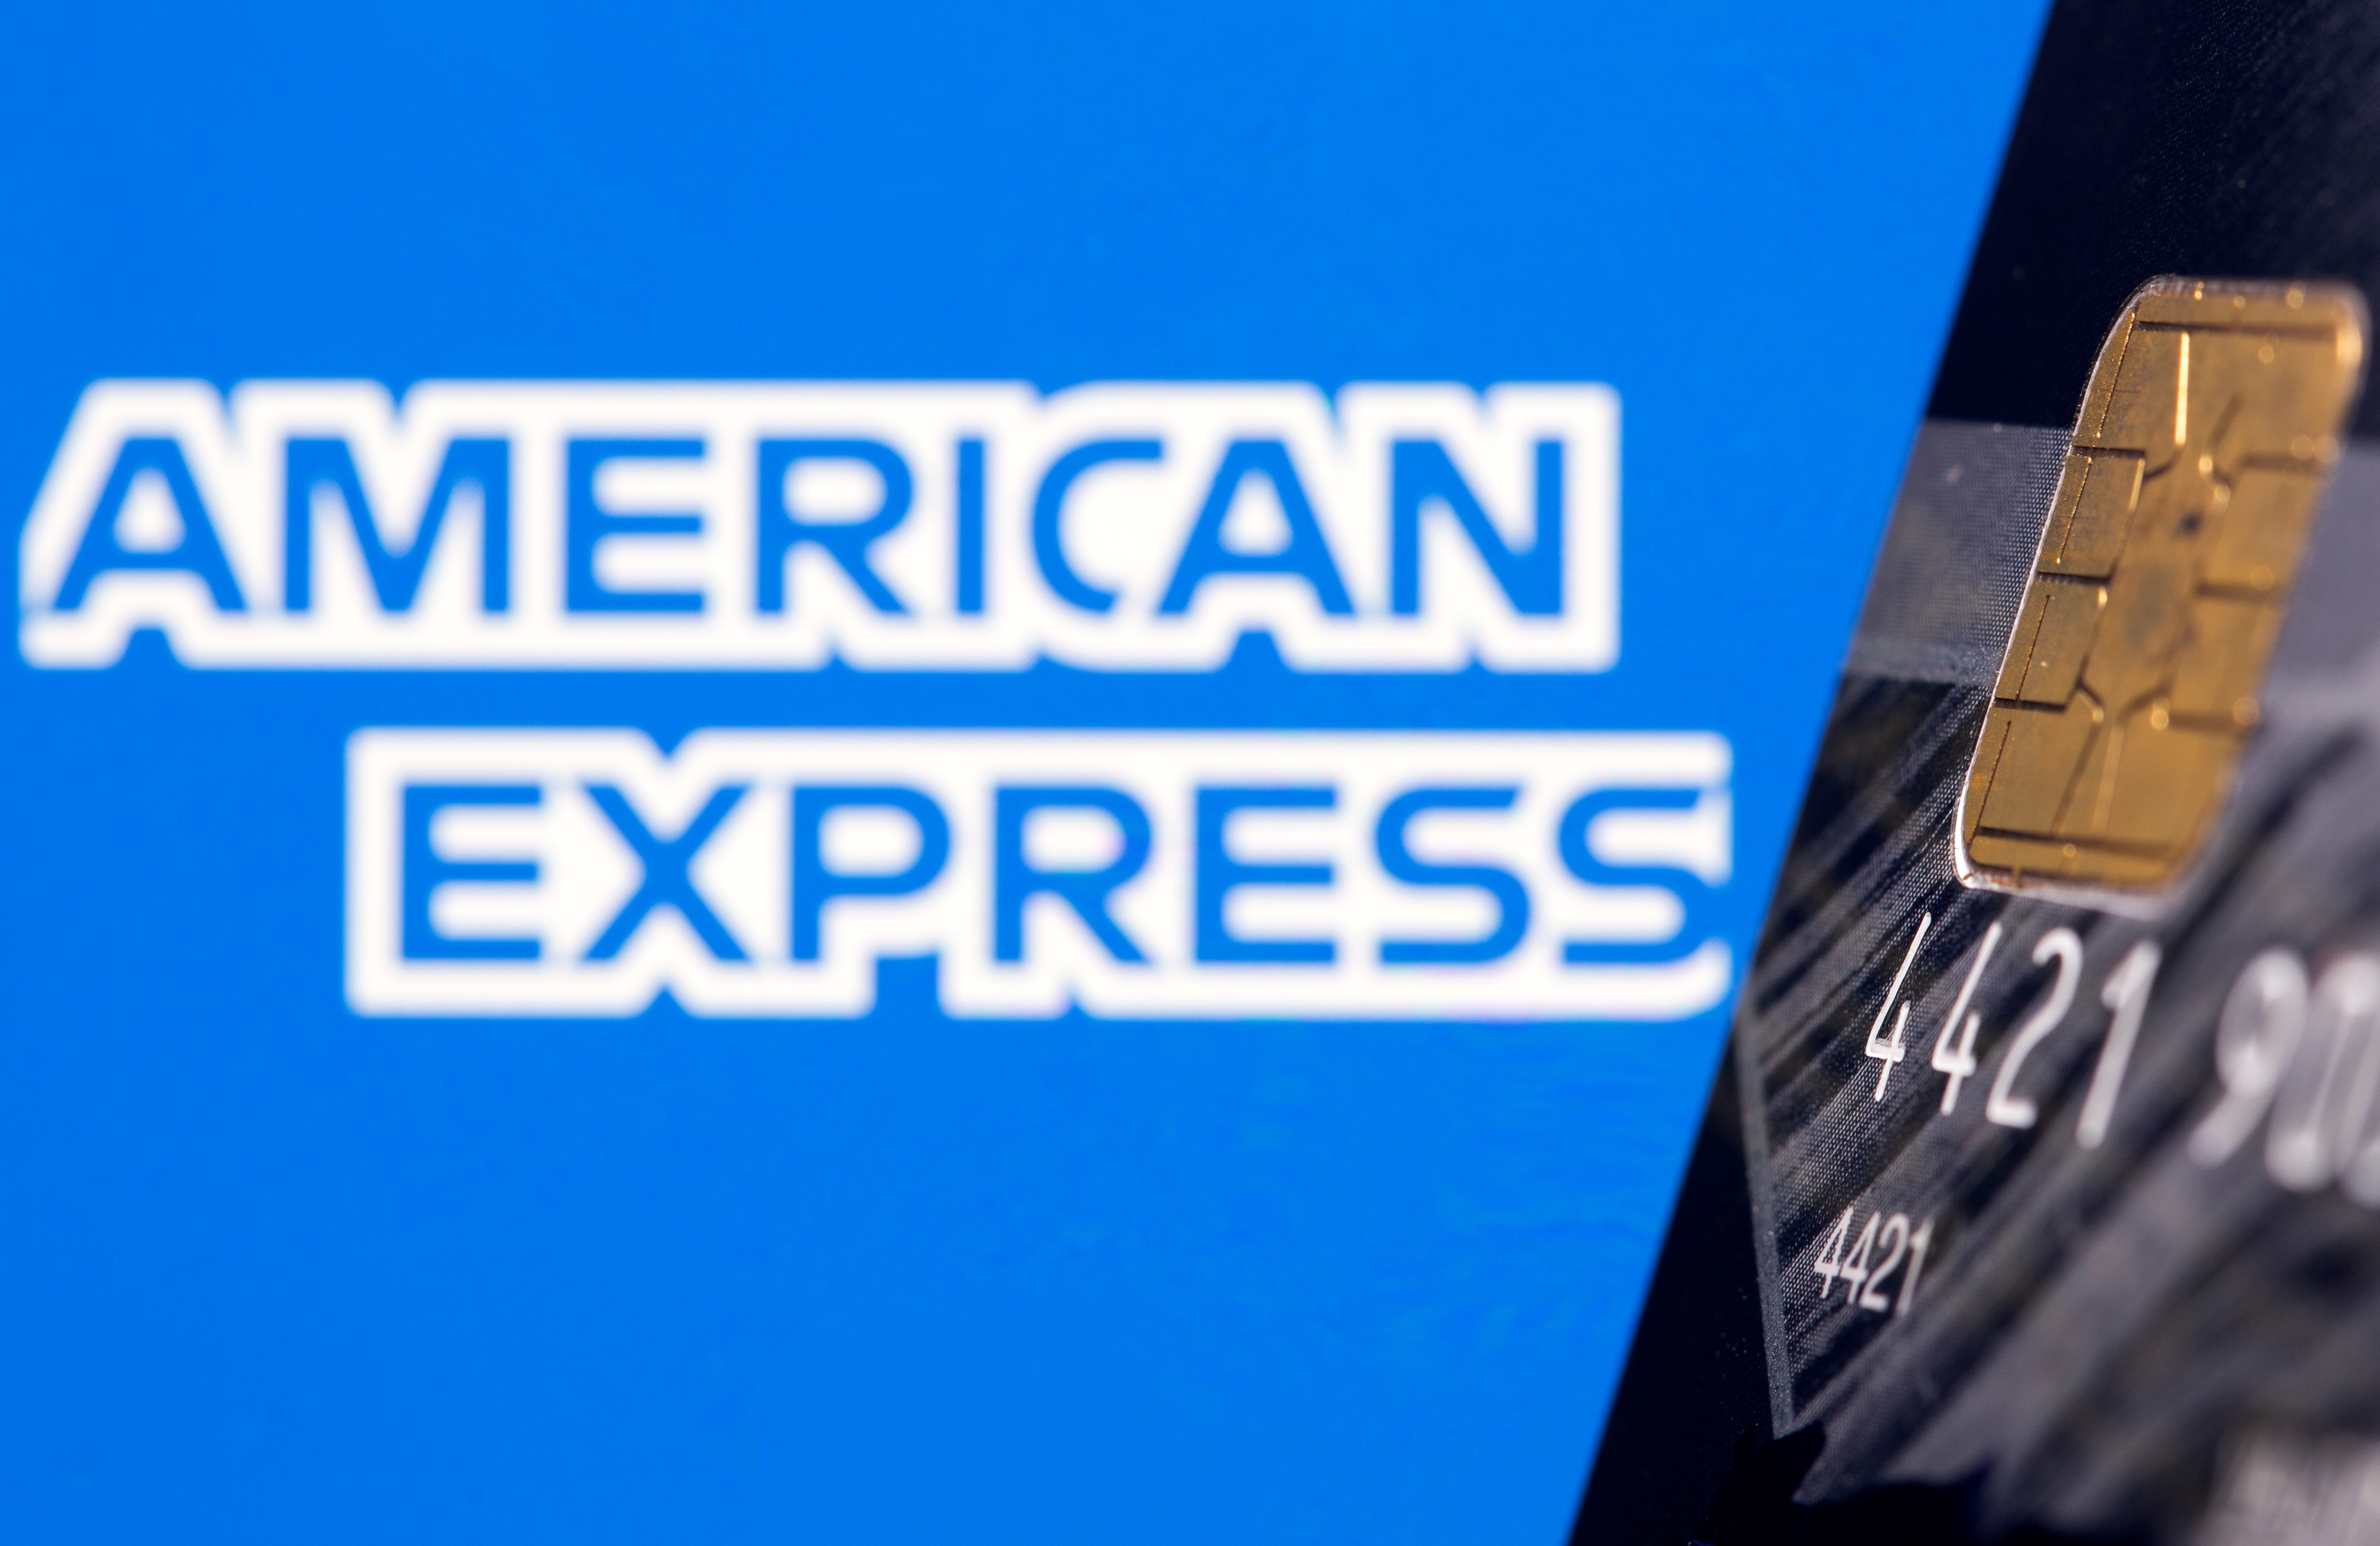

**Context**: This project is a Credit Card Default Risk Prediction Machine Learning binary classification project on American Express credit card default data. The **source** for these data contains **45,528** customers from American Express with their personal information like age, gender, number of children, and etc. as well as their credit card information such as credit limit, credit limit used, credit score, and etc.

My **goal** from this project is to extract insights from these customers' personal and credit card information in order to better understand and predict which customers might default and what features do these customers usually have and use the insights to help American Express and other financial institutions to reduce risk and cost of lending money to people who might not repay in the future. The **relevance** of this project for business and the financial industry in general, cannot be denied. For banks and financial institutions, if they can successfully identify customers who are likely to default, they can take actions to minimize their credit card default risk exposure in advance. For example, they can offer lower credit limits or higher interest rates to such risky customers. Also, if the customers are predicted as too risky, American Express can even refuse to lend money to them any more. Therefore, Credit Card Default Risk Prediction can help American Express and other financial instituions to prepare in adanvance for the uncoming risks and ensure their financial stability.

**Task**: To train a **Binary Classification Model** to predict whether the customer will default in the future based on the cutomer's personal and credit card information. Each row in the dataset represents a customer with his/her personal and credit card information.

*Source: https://www.kaggle.com/datasets/pradip11/amexpert-codelab-2021?select=train.csv* 

### Import Libraries

In [1]:
# scientific calculation packages
import numpy as np 
import pandas as pd 
from collections import Counter

# visualization packages
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

#packgages performing undersampling
from imblearn.under_sampling import RandomUnderSampler

# machine learning packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import graphviz 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix

### 2. Exploratory data analysis & data preprocessing

In [2]:
# Read data from csv file to a pandas dataframe
train_df = pd.read_csv("/Users/wangzijie/Desktop/UChicago Winter/MACS 33002 Machine Learning/Final Project/Credit Card Default/train.csv")

# check description and non-null value count on each value
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              45528 non-null  object 
 1   name                     45528 non-null  object 
 2   age                      45528 non-null  int64  
 3   gender                   45528 non-null  object 
 4   owns_car                 44981 non-null  object 
 5   owns_house               45528 non-null  object 
 6   no_of_children           44754 non-null  float64
 7   net_yearly_income        45528 non-null  float64
 8   no_of_days_employed      45065 non-null  float64
 9   occupation_type          45528 non-null  object 
 10  total_family_members     45445 non-null  float64
 11  migrant_worker           45441 non-null  float64
 12  yearly_debt_payments     45433 non-null  float64
 13  credit_limit             45528 non-null  float64
 14  credit_limit_used(%)  

In [3]:
# check the data size and display the top-5 data samples
train_df.shape, display(train_df.head())

customer_id            name  age gender owns_car owns_house  no_of_children  \
0  CST_115179        ita Bose   46      F        N          Y             0.0   
1  CST_121920  Alper Jonathan   29      M        N          Y             0.0   
2  CST_109330     Umesh Desai   37      M        N          Y             0.0   
3  CST_128288             Rie   39      F        N          Y             0.0   
4  CST_151355          McCool   46      M        Y          Y             0.0   

   net_yearly_income  no_of_days_employed occupation_type  \
0          107934.04                612.0         Unknown   
1          109862.62               2771.0        Laborers   
2          230153.17                204.0        Laborers   
3          122325.82              11941.0      Core staff   
4          387286.00               1459.0      Core staff   

   total_family_members  migrant_worker  yearly_debt_payments  credit_limit  \
0                   1.0             1.0              33070.28      18690.93   
1                   2.0             0.0              15329.53      37745.19   
2                   2.0             0.0              48416.60      41598.36   
3                   2.0             0.0              22574.36      32627.76   
4                   1.0             0.0              38282.95      52950.64   

   credit_limit_used(%)  credit_score  prev_defaults  default_in_last_6months  \
0                    73         544.0              2                        1   
1                    52         857.0              0                        0   
2                    43         650.0              0                        0   
3                    20         754.0              0                        0   
4                    75         927.0              0                        0   

   credit_card_default  
0                    1  
1                    0  
2                    0  
3                    0  
4                    0

((45528, 19), None)

In [4]:
# drop unique values 'customer_id' and 'name' because it has no prediction ability and not useful for classification
train_df.drop(["customer_id"], axis=1, inplace=True)
train_df.drop(["name"], axis=1, inplace=True)
train_df.shape
#After dropping, I now have 18 columns with 16 feature variables and 1 target variable in total.

(45528, 17)

In [5]:
# explore the number of instances from the target variable 'credit_card_default'
train_df['credit_card_default'].value_counts(normalize=True)*100

0    91.879722
1     8.120278
Name: credit_card_default, dtype: float64

**[FW]**: '0' means there will not be credit card default which is the majority class here and '1' means there will be credit card default which is the minority class.
The target variable in the training set is very imbalanced, which 0 is 91.880% of the whole sample and 1 is around 8% of the sample. The ratio between the majority class and the minority class is 11.31:1. Although undersampling the majority class may result in a loss of information, these two classes are too imbalanced that will negatively affect the model performance so I decided to undersample the class '0' to make both classes closely balanced after doing data cleaning and preprocessing.

#### 2.1 Data cleaning
- missing values
- data types
- outliers

##### 2.1.1 Missing values

In [6]:
# check missing values in the training set
null_sum = train_df.isnull().sum()
null_sum

age                          0
gender                       0
owns_car                   547
owns_house                   0
no_of_children             774
net_yearly_income            0
no_of_days_employed        463
occupation_type              0
total_family_members        83
migrant_worker              87
yearly_debt_payments        95
credit_limit                 0
credit_limit_used(%)         0
credit_score                 8
prev_defaults                0
default_in_last_6months      0
credit_card_default          0
dtype: int64

**[FW]**: There are missing values in variable 'owns_car', 'no_of_children', 'no_of_days_employed', 'total_family_members', 'migrant_worker', 'yearly_debt_payments' and 'credit_score'. The way I will handle these missing values is to fill these missing numerical values with mean and fill missing categorical values with mode to avoid the loss of information. 

In [7]:
# fill missing numerical values with mean
# variable 'no_of_children', 'no_of_days_employed', and 'total_family_members' can't have decimals
# so instead fill them with mean, fill them with median

train_df['yearly_debt_payments'].fillna(train_df['yearly_debt_payments'].mean(), inplace=True)
train_df['no_of_children'].fillna(train_df['no_of_children'].median(), inplace=True)
train_df['no_of_days_employed'].fillna(train_df['no_of_days_employed'].median(), inplace=True)
train_df['total_family_members'].fillna(train_df['total_family_members'].median(), inplace=True)
train_df['credit_score'].fillna(train_df['credit_score'].mean(), inplace=True)

In [8]:
# fill missing categorical values with mode
train_df['owns_car'].fillna(train_df['owns_car'].mode()[0], inplace=True)
train_df['migrant_worker'].fillna(train_df['migrant_worker'].mode()[0], inplace=True)

In [9]:
# double check if all missing values are handled
train_df.isnull().sum()

age                        0
gender                     0
owns_car                   0
owns_house                 0
no_of_children             0
net_yearly_income          0
no_of_days_employed        0
occupation_type            0
total_family_members       0
migrant_worker             0
yearly_debt_payments       0
credit_limit               0
credit_limit_used(%)       0
credit_score               0
prev_defaults              0
default_in_last_6months    0
credit_card_default        0
dtype: int64

##### 2.1.2 Data Types

In [10]:
# check the data types
train_df.dtypes 

age                          int64
gender                      object
owns_car                    object
owns_house                  object
no_of_children             float64
net_yearly_income          float64
no_of_days_employed        float64
occupation_type             object
total_family_members       float64
migrant_worker             float64
yearly_debt_payments       float64
credit_limit               float64
credit_limit_used(%)         int64
credit_score               float64
prev_defaults                int64
default_in_last_6months      int64
credit_card_default          int64
dtype: object

**[FW]**: By checking data types in the training set, I found that some categorical variables such as 'migrant_worker', 'default_in_last_6months' and 'credit_card_default' are treated as numerical variables. Also, by default, Pandas will store strings using the object dtype so other categorical variables like 'gender', 'owns_car', 'owns_house'and 'occupation_type' are stored as object other than category. In order to make these variables easy to be encoded in later feature engineering process, I decided to convert these variables into categorical data types.

In [11]:
# Convert the following variables to categorical data types 
cat_col = ["migrant_worker", "default_in_last_6months", "credit_card_default", "gender", "owns_car", "owns_house", "occupation_type"]
train_df[cat_col] = train_df[cat_col].astype('category')
train_df.dtypes 
# Now all categorical variables are stored into category


age                           int64
gender                     category
owns_car                   category
owns_house                 category
no_of_children              float64
net_yearly_income           float64
no_of_days_employed         float64
occupation_type            category
total_family_members        float64
migrant_worker             category
yearly_debt_payments        float64
credit_limit                float64
credit_limit_used(%)          int64
credit_score                float64
prev_defaults                 int64
default_in_last_6months    category
credit_card_default        category
dtype: object

##### 2.1.3 Outliers

In [12]:
# Check outliers for all categorical variables
for n in cat_col:
    print(train_df[n].value_counts())

0.0    37389
1.0     8139
Name: migrant_worker, dtype: int64
0    43227
1     2301
Name: default_in_last_6months, dtype: int64
0    41831
1     3697
Name: credit_card_default, dtype: int64
F      29957
M      15570
XNA        1
Name: gender, dtype: int64
N    30290
Y    15238
Name: owns_car, dtype: int64
Y    31642
N    13886
Name: owns_house, dtype: int64
Unknown                  14299
Laborers                  8134
Sales staff               4725
Core staff                4062
Managers                  3168
Drivers                   2747
High skill tech staff     1682
Accountants               1474
Medicine staff            1275
Security staff            1025
Cooking staff              902
Cleaning staff             665
Private service staff      387
Low-skill Laborers         336
Waiters/barmen staff       203
Secretaries                199
Realty agents              101
HR staff                    78
IT staff                    66
Name: occupation_type, dtype: int64


**[FW]**: I identified three issues from above. Firstly, for 'gender', there's one outlier 'XNA'. Since it's only one outlier, I decided to just simply remove it. Secondly, for 'occupation_type', I think IT staff is the same as high skill tech staff, and laborers in genearl are defined as "a person doing unskilled manual work for wages" so I think merging the minority groups 'IT staff' and 'Low-skill Laborers' to the majority group 'High skill tech staff' and 'Laborers' is reasonable. Thirdly, 'Unknown' is predominatly occupied in the variable occupation_type. Among all the choices like replace unknown with some meaningful predictions using machine learning mechanisms or drop all rows with 'occupation_type' equal to 'unknown', or just treating it as a separated category of 'occupation_type', I won't drop all rows with value = 'unknown' since I then need to drop 31% of data in the training set. For the rest of two choices, I decided to keep the 'Unknown' in the column since if I use machine learning mechanisms to predict all the unknown values, it may already build bias and lead to overfitting issues before I start to build machine learning models for the whole dataset. I think just keeping the 'Unknown' as a separate occupation type will give the models more information and less bias than just simply dropping them all or making predictions to these 'Unknown'. 

In [13]:
# drop one outlier in feature variable'gender'

# get the index of the first row where gender is 'XNA'
index_to_drop = train_df[train_df['gender'] == 'XNA'].index[0] 

# drop the row at the specified index
train_df.drop(index_to_drop, inplace=True) 
train_df.shape

(45527, 17)

In [14]:
# merge minority categories with majority ones (e.g., IT staff --> High skill tech staff,
# Low-skill Laborers-->Laborers)
train_df['occupation_type'].replace(['IT staff', 'Low-skill Laborers'],['High skill tech staff', 'High skill tech staff'], inplace=True)
train_df['occupation_type'].value_counts()



Unknown                  14299
Laborers                  8134
Sales staff               4725
Core staff                4062
Managers                  3168
Drivers                   2747
High skill tech staff     2083
Accountants               1474
Medicine staff            1275
Security staff            1025
Cooking staff              902
Cleaning staff             665
Private service staff      387
Waiters/barmen staff       203
Secretaries                199
Realty agents              101
HR staff                    78
Name: occupation_type, dtype: int64

Text(0.5, 1.0, 'credit_score')

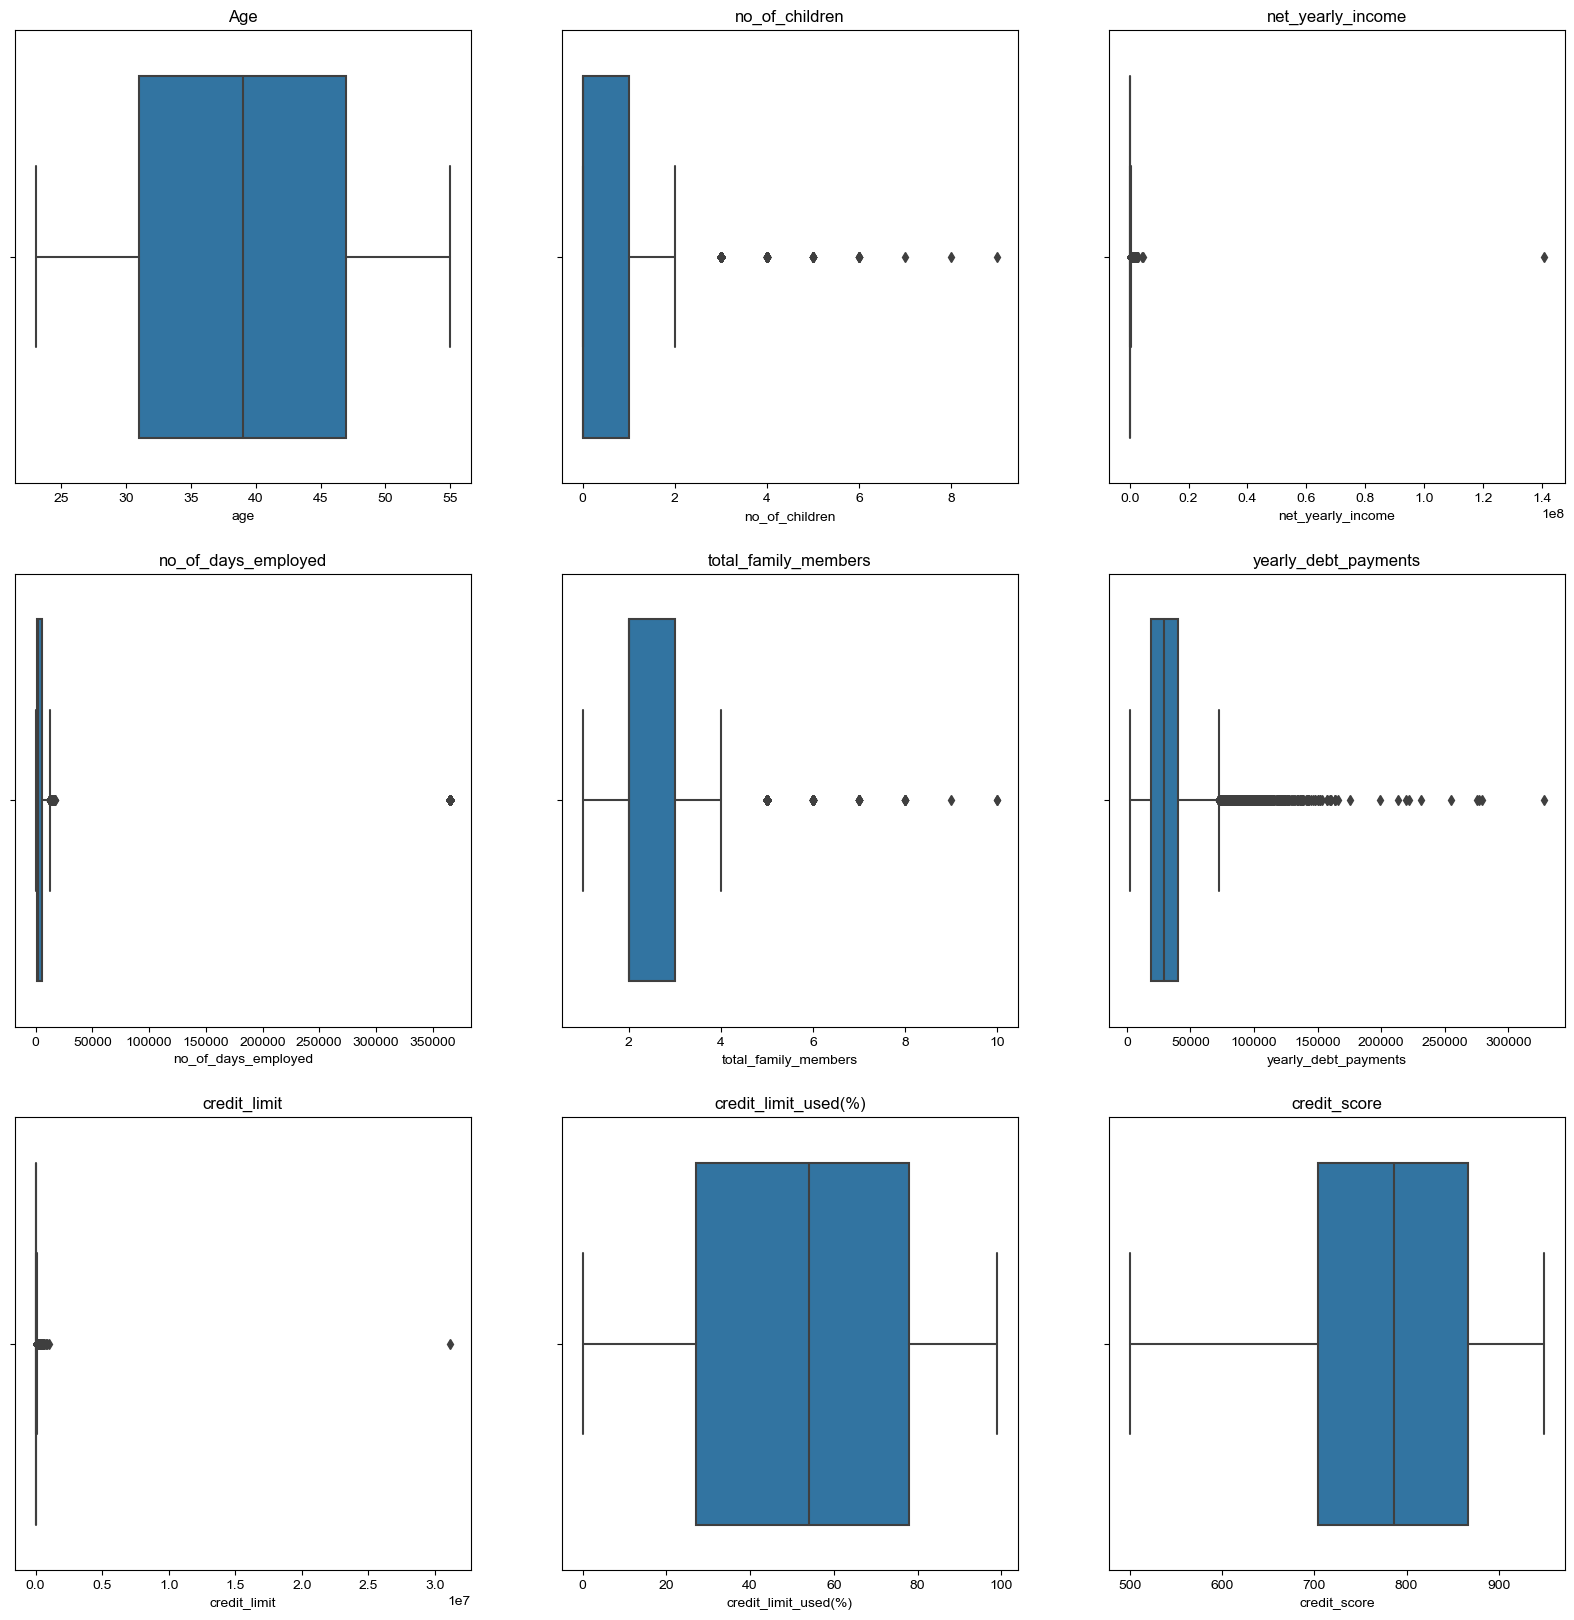

In [15]:
# Check outliers for all numerical variables by plotting boxplots

# create a figure with a 4x4 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

# draw box plot to check outliers for column "age"
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=train_df['age'], orient='h', ax=axs[0, 0])
axs[0, 0].set_title('Age')

# draw box plot to check outliers for column "no_of_children"
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=train_df['no_of_children'], orient='h', ax=axs[0, 1])
axs[0, 1].set_title('no_of_children')

# draw box plot to check outliers for column "net_yearly_income"
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=train_df['net_yearly_income'], orient='h', ax=axs[0, 2])
axs[0, 2].set_title('net_yearly_income')

# draw box plot to check outliers for column "no_of_days_employed"
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=train_df['no_of_days_employed'], orient='h', ax=axs[1, 0])
axs[1, 0].set_title('no_of_days_employed')

# draw box plot to check outliers for column "total_family_members"
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=train_df['total_family_members'], orient='h', ax=axs[1, 1])
axs[1, 1].set_title('total_family_members')

# draw box plot to check outliers for column "yearly_debt_payments"
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=train_df['yearly_debt_payments'], orient='h', ax=axs[1, 2])
axs[1, 2].set_title('yearly_debt_payments')

# draw box plot to check outliers for column "credit_limit"
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=train_df['credit_limit'], orient='h', ax=axs[2, 0])
axs[2, 0].set_title('credit_limit')

# draw box plot to check outliers for column "credit_limit_used(%)"
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=train_df['credit_limit_used(%)'], orient='h', ax=axs[2, 1])
axs[2, 1].set_title('credit_limit_used(%)')

# draw box plot to check outliers for column "credit_score"
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=train_df['credit_score'], orient='h', ax=axs[2, 2])
axs[2, 2].set_title('credit_score')


<AxesSubplot:xlabel='prev_defaults'>

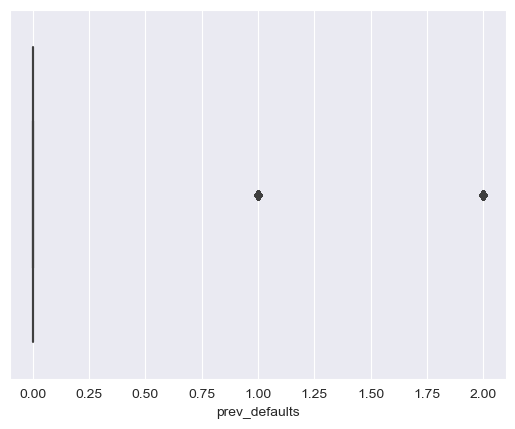

In [16]:
# draw box plot to check outliers for column "prev_defaults"
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=train_df['prev_defaults'], orient='h')

**[FW]**: From the 9 boxplots above, it's obvious that the feature variable 'no_of_children', 'net_yearly_income', 'no_of_days_employed', 'total_family_members', 'yearly_debt_payments', 'credit_limit', and 'prev_defaults' have outliers. Next, I want to deep dive into the outliers more statistically and decide a threshold for each feature variable to remove all outliers.

In [17]:
# descriptive statistics for all numerical columns

num_col = ["age", "no_of_children", "net_yearly_income", "no_of_days_employed", "total_family_members", 
          "yearly_debt_payments", "credit_limit", "credit_limit_used(%)", "credit_score", "prev_defaults"]

train_df[num_col].describe()

age  no_of_children  net_yearly_income  no_of_days_employed  \
count  45527.000000    45527.000000       4.552700e+04         45527.000000   
mean      38.993125        0.413469       2.006556e+05         66945.758078   
std        9.543900        0.719942       6.690814e+05        138769.618226   
min       23.000000        0.000000       2.717061e+04             2.000000   
25%       31.000000        0.000000       1.263445e+05           946.500000   
50%       39.000000        0.000000       1.717115e+05          2224.000000   
75%       47.000000        1.000000       2.406042e+05          5688.000000   
max       55.000000        9.000000       1.407590e+08        365252.000000   

       total_family_members  yearly_debt_payments  credit_limit  \
count          45527.000000          45527.000000  4.552700e+04   
mean               2.157753          31797.340841  4.354793e+04   
std                0.910735          17251.703065  1.487863e+05   
min                1.000000           2237.470000  4.003140e+03   
25%                2.000000          19241.070000  2.397361e+04   
50%                2.000000          29122.500000  3.568790e+04   
75%                3.000000          40535.775000  5.343524e+04   
max               10.000000         328112.860000  3.112997e+07   

       credit_limit_used(%)  credit_score  prev_defaults  
count          45527.000000  45527.000000   45527.000000  
mean              52.235289    782.793756       0.060711  
std               29.377176    100.610596       0.264632  
min                0.000000    500.000000       0.000000  
25%               27.000000    704.000000       0.000000  
50%               54.000000    786.000000       0.000000  
75%               78.000000    867.000000       0.000000  
max               99.000000    949.000000       2.000000

In [18]:
# show lower_thresh and upper_thresh for each feature variable
for a in num_col:
    Q1 = train_df[a].quantile(0.25)
    Q3 = train_df[a].quantile(0.75)
    IQR = Q3 - Q1
    lower_thresh = Q1 - 1.5 * IQR
    upper_thresh = Q3 + 1.5 * IQR
    print(a,":", lower_thresh, upper_thresh)

age : 7.0 71.0
no_of_children : -1.5 2.5
net_yearly_income : -45045.11999999998 411993.76
no_of_days_employed : -6165.75 12800.25
total_family_members : 0.5 4.5
yearly_debt_payments : -12700.987499999992 72477.83249999999
credit_limit : -20218.834999999992 97627.685
credit_limit_used(%) : -49.5 154.5
credit_score : 459.5 1111.5
prev_defaults : 0.0 0.0


**[FW]**: From the statistical tables, I double checked and made sure there are no outliers in 'age', 'credit_limit_used(%)', and 'credit_score' which I can also see from the box plots above. So now I just need to focus on removing outliers for the rest of 7 numerical variables. 

In [19]:
# check how many outliers the 7 variables have and decide thresholds to remove the outliers
num_col_7 = ["no_of_children", "net_yearly_income", "no_of_days_employed", "total_family_members", 
          "yearly_debt_payments", "credit_limit", "prev_defaults"]
thresholds = [2.5, 411993.76, 12800.25, 4.5, 72477.83249999999, 97627.685, 0]

# when setting threshold = 4, the number of outliers in the variable 'no_of_children'
len(train_df[train_df["no_of_children"] > 3])
# In 2022, there was an average of 1.94 children under 18 per family in the United States
# but some family may have triplets so I think set the threshold to 3 reasonable. 

82

In [20]:
# remove outliers for the variable 'no_of_children'
print("Data size before removing outliers in the variable 'no_of_children:", train_df.shape)
train_df.drop(train_df[train_df['no_of_children'] > 3].index, inplace=True)
print("Data size after removing outliers in the variable 'no_of_children:", train_df.shape)

Data size before removing outliers in the variable 'no_of_children: (45527, 17)
Data size after removing outliers in the variable 'no_of_children: (45445, 17)


In [21]:
# when setting threshold = 450000, the number of outliers in the variable 'net_yearly_income'
print(len(train_df[train_df["net_yearly_income"] > 450000]))

# remove outliers for the variable 'no_of_children'
print("Data size before removing outliers in the variable 'net_yearly_income:", train_df.shape)
train_df.drop(train_df[train_df['net_yearly_income'] > 450000].index, inplace=True)
print("Data size after removing outliers in the variable 'net_yearly_income:", train_df.shape)

1330
Data size before removing outliers in the variable 'net_yearly_income: (45445, 17)
Data size after removing outliers in the variable 'net_yearly_income: (44115, 17)


In [22]:
# when setting threshold = 18250, the number of outliers in the variable 'no_of_days_employed'
print(len(train_df[train_df["no_of_days_employed"] > 18250]))
#In America, people usually retire at the age of 65, so probably at most 50 years to work
# 50 years = 18250 days, choose 18250 as the threshold

# remove outliers for the variable 'no_of_days_employed'
print("Data size before removing outliers in the variable 'no_of_days_employed:", train_df.shape)
train_df.drop(train_df[train_df['no_of_days_employed'] > 18250].index, inplace=True)
print("Data size after removing outliers in the variable 'no_of_days_employed:", train_df.shape)

8006
Data size before removing outliers in the variable 'no_of_days_employed: (44115, 17)
Data size after removing outliers in the variable 'no_of_days_employed: (36109, 17)


In [23]:
# when setting threshold = 5, the number of outliers in the variable 'total_family_members'
print(len(train_df[train_df["total_family_members"] > 5]))

# remove outliers for the variable 'total_family_members'
print("Data size before removing outliers in the variable 'total_family_members:", train_df.shape)
train_df.drop(train_df[train_df['total_family_members'] > 5].index, inplace=True)
print("Data size after removing outliers in the variable 'total_family_members:", train_df.shape)

2
Data size before removing outliers in the variable 'total_family_members: (36109, 17)
Data size after removing outliers in the variable 'total_family_members: (36107, 17)


In [24]:
# when setting threshold = 75000, the number of outliers in the variable 'yearly_debt_payments'
print(len(train_df[train_df["yearly_debt_payments"] > 75000]))

# remove outliers for the variable 'yearly_debt_payments'
print("Data size before removing outliers in the variable 'yearly_debt_payments:", train_df.shape)
train_df.drop(train_df[train_df['yearly_debt_payments'] > 75000].index, inplace=True)
print("Data size after removing outliers in the variable 'yearly_debt_payments:", train_df.shape)

622
Data size before removing outliers in the variable 'yearly_debt_payments: (36107, 17)
Data size after removing outliers in the variable 'yearly_debt_payments: (35485, 17)


In [25]:
# when setting threshold = 100000, the number of outliers in the variable 'credit_limit'
print(len(train_df[train_df["credit_limit"] > 100000]))
# In the states, 100000 is the highest credit limit a person can get.

# remove outliers for the variable 'yearly_debt_payments'
print("Data size before removing outliers in the variable 'credit_limit:", train_df.shape)
train_df.drop(train_df[train_df['credit_limit'] > 100000].index, inplace=True)
print("Data size after removing outliers in the variable 'credit_limit:", train_df.shape)

865
Data size before removing outliers in the variable 'credit_limit: (35485, 17)
Data size after removing outliers in the variable 'credit_limit: (34620, 17)


In [26]:
#when setting threshold = 18250, the number of outliers in the variable 'prev_defaults'
len(train_df[train_df["prev_defaults"] > 0])

# It's possible for a person to previouly default several times.
# Since the maximum prev_defaults is 2, it's reasonable not to remove any outliers.

# reset index after dropping all outliers
train_df.reset_index(inplace=True, drop=True)

print(train_df.shape)

(34620, 17)


**[FW]**: After removing all outliers for both categorical and numerical values, the training set contains 34620 data and I can now go back to address the data imbalance problem by undersampling the majority class to get closer to the number of data in the minority group.

#### 2.2 Undersample training data

In [27]:
# re-check the distribution of two classes in the training set
train_df['credit_card_default'].value_counts(normalize=True)*100
train_df['credit_card_default'].value_counts()

0    31552
1     3068
Name: credit_card_default, dtype: int64

**[FW]**: After dealing with missing values, data types, and outliers, the two classes just become a little more balanced changing from 91.88 : 8.12 to 91.14 : 8.86 but still very imbalanced. So it's still very necessary to undersample the majority class, in my case, the class '0' which means there will not be credit card default, to make it get close to the minority class '1' which means there will be credit card default.

In [28]:
# undersampling the class "0" to make these two classes nearly balanced

# create the undersampler object
undersample = RandomUnderSampler(sampling_strategy=0.6, random_state=42)

# fit and apply the undersampling to the dataset
X_undersampled, y_undersampled = undersample.fit_resample(train_df.iloc[:, 0:16], train_df['credit_card_default'])

#
X_undersampled.shape, y_undersampled.shape, y_undersampled.value_counts() 
# y_undersampled.value_counts(normalize=True)*100

((8181, 16),
 (8181,),
 0    5113
 1    3068
 Name: credit_card_default, dtype: int64)

**[FW]**: To make a balance between if the two classes are balanced and if there's enough data to train the machine learning models, I chose not to make the two classes perfectly balanced, otherwise I will only have around 6,000 data to train the models. The ratio of class '0' and '1' I chose is 10:6 (1.67:1). which is already being balanced a lot compared to the original ratio of around 10:1. In this way, I can make the two classes nearly balanced and at the same time I have over 8,000 data to train the following models.

#### 2.3 Data transformation
- normalize numerical data for Logistic regression and SVM models

In [29]:
# normalize all numerical feature variables
normalized_X_undersampled = X_undersampled[:]
scaler = MinMaxScaler(feature_range=(0,1))
for d in num_col:
    normalized_X_undersampled[d] = scaler.fit_transform(normalized_X_undersampled[[d]].values)
normalized_X_undersampled

age gender owns_car owns_house  no_of_children  net_yearly_income  \
0     0.31250      F        N          N        0.000000           0.143724   
1     0.87500      F        N          N        0.000000           0.405017   
2     0.15625      F        N          N        0.333333           0.318872   
3     0.78125      F        N          N        0.666667           0.690263   
4     0.43750      M        N          Y        0.000000           0.290793   
...       ...    ...      ...        ...             ...                ...   
8176  0.56250      F        N          Y        0.000000           0.520801   
8177  0.96875      M        N          N        0.666667           0.271052   
8178  0.65625      F        N          Y        0.333333           0.252362   
8179  1.00000      F        N          Y        0.000000           0.204153   
8180  0.96875      F        N          Y        0.666667           0.527528   

      no_of_days_employed        occupation_type  total_family_members  \
0                0.525757             Core staff                  0.00   
1                0.127234  High skill tech staff                  0.00   
2                0.048101             Core staff                  0.25   
3                0.173784               Managers                  0.75   
4                0.081989                Drivers                  0.00   
...                   ...                    ...                   ...   
8176             0.010241             Core staff                  0.25   
8177             0.117366               Laborers                  0.75   
8178             0.180114               Laborers                  0.50   
8179             0.447741             Core staff                  0.25   
8180             0.140268               Laborers                  0.50   

     migrant_worker  yearly_debt_payments  credit_limit  credit_limit_used(%)  \
0               0.0              0.095020      0.249865              0.909091   
1               0.0              0.331019      0.203420              0.575758   
2               0.0              0.388858      0.468188              0.343434   
3               0.0              0.355337      0.750694              0.404040   
4               1.0              0.277797      0.413462              0.383838   
...             ...                   ...           ...                   ...   
8176            0.0              0.745103      0.411189              0.828283   
8177            1.0              0.498686      0.330353              0.919192   
8178            1.0              0.472416      0.250017              0.838384   
8179            0.0              0.608572      0.420303              0.989899   
8180            0.0              0.478059      0.433500              0.717172   

      credit_score  prev_defaults default_in_last_6months  
0         0.824053            0.0                       0  
1         0.710468            0.0                       0  
2         0.951002            0.0                       0  
3         0.853007            0.0                       0  
4         0.465479            0.0                       0  
...            ...            ...                     ...  
8176      0.026726            0.5                       1  
8177      0.106904            1.0                       1  
8178      0.175947            0.5                       1  
8179      0.405345            0.0                       0  
8180      0.394209            0.0                       0  

[8181 rows x 16 columns]

#### 2.4 Feature engineering
- encode categorical data (one-hot encoder) for logistic regression and SVM models
- numerical data (directly use the values)

In [30]:
# all categorical feature variables
cat_col = ["gender", "owns_car", "owns_house", "occupation_type", "default_in_last_6months"]

# encoding the feature "gender" using one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore')
df1 = pd.DataFrame(ohe.fit_transform(normalized_X_undersampled[['gender']]).toarray()).rename(columns={i: catg for i, catg in enumerate(ohe.categories_[0])})

# encoding the feature "owns_car" using one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore')
df2 = pd.DataFrame(ohe.fit_transform(normalized_X_undersampled[['owns_car']]).toarray()).rename(columns={0:"Not_Own_Car", 1:"Own_Car"})

# encoding the feature "owns_house" using one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore')
df3 = pd.DataFrame(ohe.fit_transform(normalized_X_undersampled[['owns_house']]).toarray()).rename(columns={0:"Noe_Own_House", 1:"Own_House"})

# encoding the feature "occupation_type" using one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore')
df4 = pd.DataFrame(ohe.fit_transform(normalized_X_undersampled[['occupation_type']]).toarray()).rename(columns={i: catg for i, catg in enumerate(ohe.categories_[0])})

# encoding the feature "migrant_worker" using one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore')
df5 = pd.DataFrame(ohe.fit_transform(normalized_X_undersampled[['migrant_worker']]).toarray()).rename(columns={0: "Not_Migrant_Worker", 1: "Migrant_Worker"})

# encoding the feature "default_in_last_6months" using one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore')
df6 = pd.DataFrame(ohe.fit_transform(normalized_X_undersampled[['default_in_last_6months']]).toarray()).rename(columns={0: "No_Default_In_Last_6months", 1: "Default_In_Last_6months"})


In [31]:
# merge encoded dataframes with other feature variables in the original datafram-
df_total = [df1, df2, df3, 
            pd.DataFrame(normalized_X_undersampled['no_of_children']), 
             pd.DataFrame(normalized_X_undersampled['net_yearly_income']), 
              pd.DataFrame(normalized_X_undersampled['no_of_days_employed']),df4,
               pd.DataFrame(normalized_X_undersampled['total_family_members']), df5,
                pd.DataFrame(normalized_X_undersampled['yearly_debt_payments']),
                 pd.DataFrame(normalized_X_undersampled['credit_limit']),
                  pd.DataFrame(normalized_X_undersampled['credit_limit_used(%)']),
                   pd.DataFrame(normalized_X_undersampled['credit_score']),
                    pd.DataFrame(normalized_X_undersampled['prev_defaults']), df6]

# Initialize the merged DataFrame with the first DataFrame in the list
merged_norm_X_undersamp = pd.DataFrame(normalized_X_undersampled['age'])

# Loop through the remaining DataFrames and merge them with the merged DataFrame
for df in df_total:
    merged_norm_X_undersamp = merged_norm_X_undersamp.merge(df, left_index=True, right_index=True)
merged_norm_X_undersamp.shape, display(merged_norm_X_undersamp.head())

age    F    M  Not_Own_Car  Own_Car  Noe_Own_House  Own_House  \
0  0.31250  1.0  0.0          1.0      0.0            1.0        0.0   
1  0.87500  1.0  0.0          1.0      0.0            1.0        0.0   
2  0.15625  1.0  0.0          1.0      0.0            1.0        0.0   
3  0.78125  1.0  0.0          1.0      0.0            1.0        0.0   
4  0.43750  0.0  1.0          1.0      0.0            0.0        1.0   

   no_of_children  net_yearly_income  no_of_days_employed  ...  \
0        0.000000           0.143724             0.525757  ...   
1        0.000000           0.405017             0.127234  ...   
2        0.333333           0.318872             0.048101  ...   
3        0.666667           0.690263             0.173784  ...   
4        0.000000           0.290793             0.081989  ...   

   total_family_members  Not_Migrant_Worker  Migrant_Worker  \
0                  0.00                 1.0             0.0   
1                  0.00                 1.0             0.0   
2                  0.25                 1.0             0.0   
3                  0.75                 1.0             0.0   
4                  0.00                 0.0             1.0   

   yearly_debt_payments  credit_limit  credit_limit_used(%)  credit_score  \
0              0.095020      0.249865              0.909091      0.824053   
1              0.331019      0.203420              0.575758      0.710468   
2              0.388858      0.468188              0.343434      0.951002   
3              0.355337      0.750694              0.404040      0.853007   
4              0.277797      0.413462              0.383838      0.465479   

   prev_defaults  No_Default_In_Last_6months  Default_In_Last_6months  
0            0.0                         1.0                      0.0  
1            0.0                         1.0                      0.0  
2            0.0                         1.0                      0.0  
3            0.0                         1.0                      0.0  
4            0.0                         1.0                      0.0  

[5 rows x 37 columns]

((8181, 37), None)

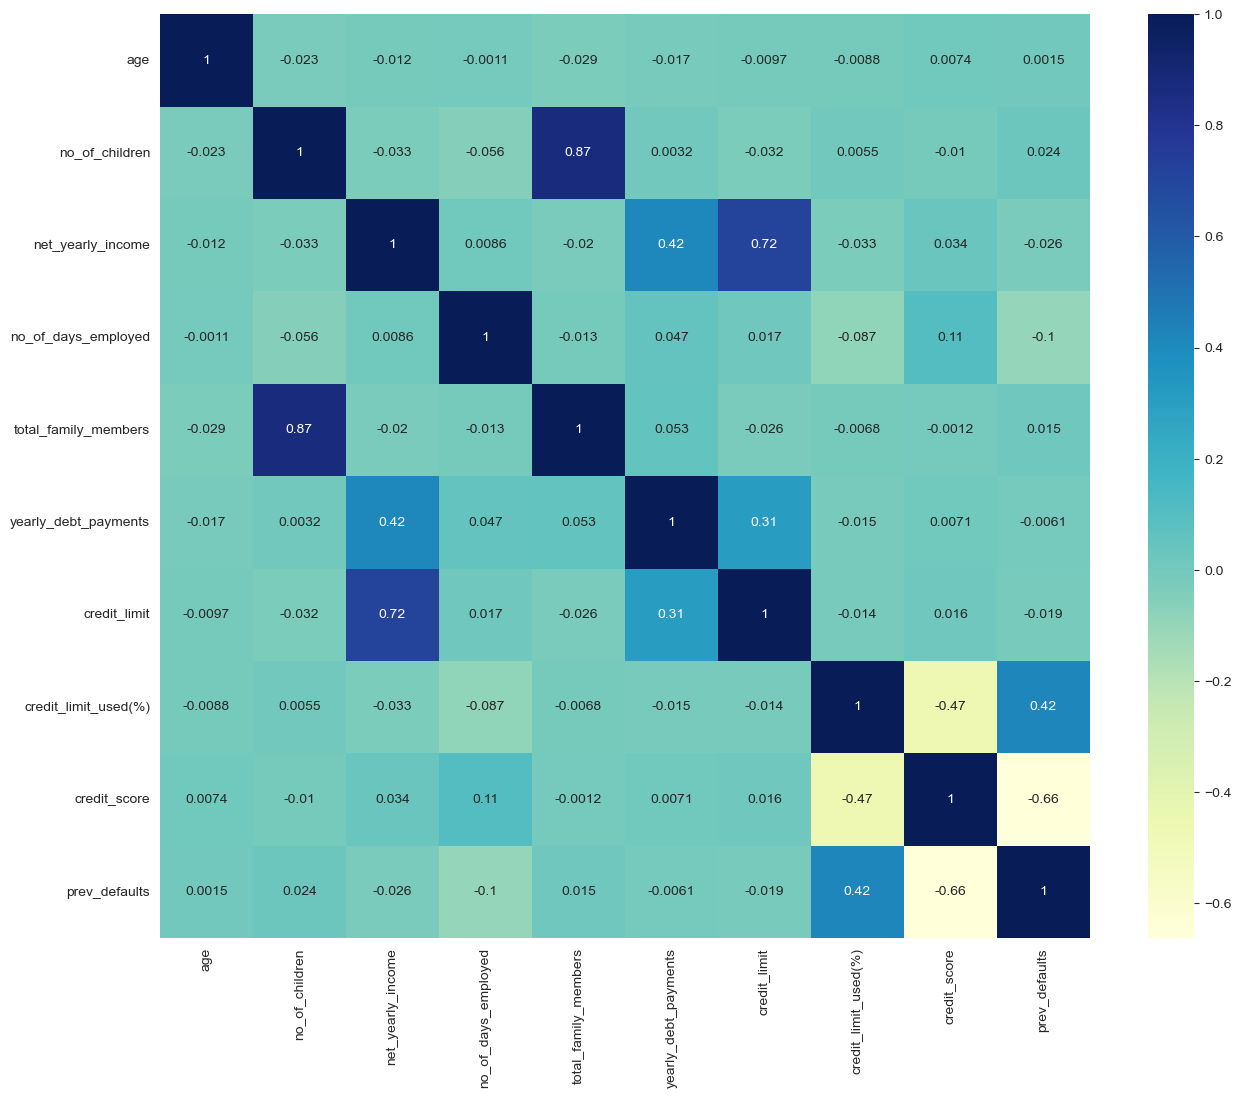

In [32]:
# Additional Exploratory Data Analysis and data preprocessing
# heatmap to check relationships between numerical variables
plt.figure(figsize=(15,12))
sns.heatmap(normalized_X_undersampled.corr(), annot=True, cmap='YlGnBu');

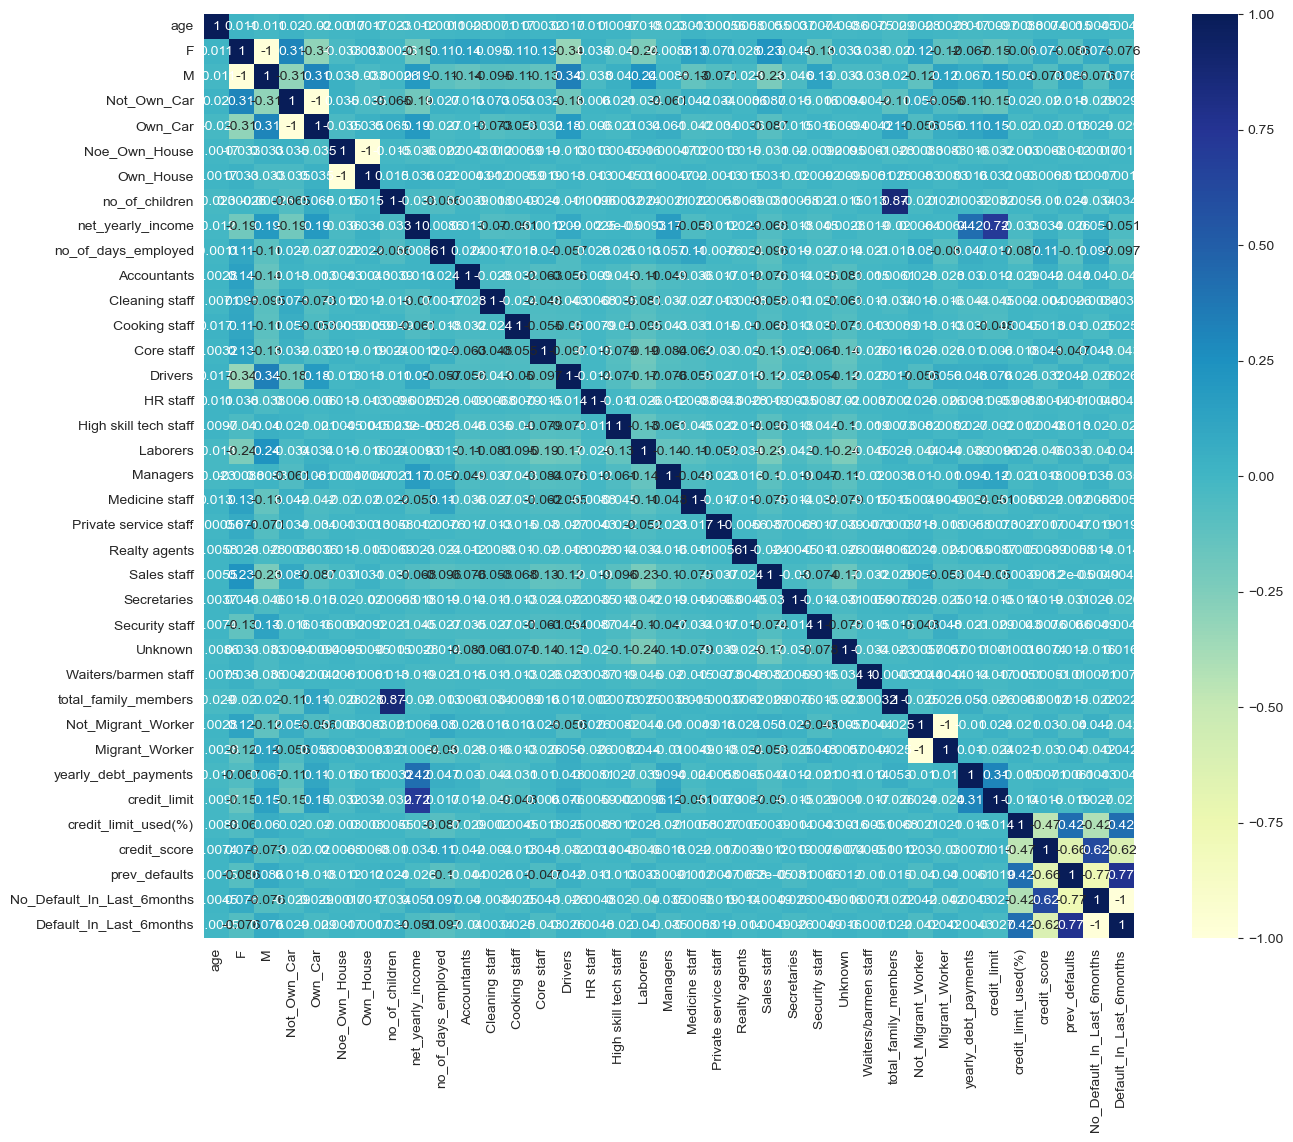

In [33]:
plt.figure(figsize=(15,12))
sns.heatmap(merged_norm_X_undersamp.corr(), annot=True, cmap='YlGnBu');

In [34]:
# check unique values in the feature 'no_of_children' and 'total_family_members' 
# decide which feature to remove to avoid the multicollinearity
merged_norm_X_undersamp['no_of_children'].value_counts(), merged_norm_X_undersamp['total_family_members'].value_counts()


(0.000000    5277
 0.333333    1976
 0.666667     807
 1.000000     121
 Name: no_of_children, dtype: int64,
 0.25    3984
 0.50    1701
 0.00    1618
 0.75     762
 1.00     116
 Name: total_family_members, dtype: int64)

In [35]:
# remove the feature 'no_of_children'
print("Data size before removing the variable 'no_of_children:", merged_norm_X_undersamp.shape)
merged_norm_X_undersamp.drop(["no_of_children"], axis=1, inplace=True)
print("Data size after removing the variable 'no_of_children:", merged_norm_X_undersamp.shape)

Data size before removing the variable 'no_of_children: (8181, 37)
Data size after removing the variable 'no_of_children: (8181, 36)


In [36]:
# remove the feature 'net_yearly_income' to avoid multicollinearity with 'credit limit'
print("Data size before removing the variable 'net_yearly_income:", merged_norm_X_undersamp.shape)
merged_norm_X_undersamp.drop(["net_yearly_income"], axis=1, inplace=True)
print("Data size after removing the variable 'net_yearly_income:", merged_norm_X_undersamp.shape)

Data size before removing the variable 'net_yearly_income: (8181, 36)
Data size after removing the variable 'net_yearly_income: (8181, 35)


In [37]:
# check unique values in the feature 'prev_defaults'  
# decide if feature 'prev_defaults' can be removed to avoid the multicollinearity
merged_norm_X_undersamp['prev_defaults'].value_counts()


0.0    6118
0.5    1814
1.0     249
Name: prev_defaults, dtype: int64

In [38]:
# remove the feature 'prev_defaults'
print("Data size before removing the variable 'prev_defaults:", merged_norm_X_undersamp.shape)
merged_norm_X_undersamp.drop(["prev_defaults"], axis=1, inplace=True)
print("Data size after removing the variable 'prev_defaults:", merged_norm_X_undersamp.shape)

Data size before removing the variable 'prev_defaults: (8181, 35)
Data size after removing the variable 'prev_defaults: (8181, 34)


In [39]:
# remove the features 'No_Default_In_Last_6months' and 'Default_In_Last_6months'
print("Data size before removing the variable 'No_Default_In_Last_6months and 'Default_In_Last_6months':", merged_norm_X_undersamp.shape)
merged_norm_X_undersamp.drop(["No_Default_In_Last_6months"], axis=1, inplace=True)
merged_norm_X_undersamp.drop(["Default_In_Last_6months"], axis=1, inplace=True)
print("Data size after removing the variable 'No_Default_In_Last_6months and 'Default_In_Last_6months':", merged_norm_X_undersamp.shape)


Data size before removing the variable 'No_Default_In_Last_6months and 'Default_In_Last_6months': (8181, 34)
Data size after removing the variable 'No_Default_In_Last_6months and 'Default_In_Last_6months': (8181, 32)


**[FW]**: According to the heatmaps, it seems that there are some collinearities among some of these numerical variables. For example, there's a strong positive correlation (0.87) between no_of_children and total_family_members, which makes sense because more number of children means a bigger family. There's also a strong positive correlation (0.72) between net_yearly_income and credit_limit, which also makes sense since if a customer has more net yearly income which means the customer has more ability of pay the credit back, the bank will give the customer more credit limits. Also, there's a relatively strong negative correlation (-0.66) between credit_score and prev_defaults and (-0.47) between credit_score and credit_limit_used(%), which is also reasonable because if a customer's credit score is very low, then the customer is very possible to default previously that leads to his/her low credit scores and the customer may already use his/her credit limit a lot. I decided to remove the feature 'no_of_children' since it first has predominately value=0 and also it has a very strong correlation with 'total_family_member' which will lead to issues of multicollinearity. I also removed the feature 'net_yearly_income' to avoid the collinearity issue because it has a strong correlation with 'credit limit'.

According to the second heatmap, there are more collinearities among the five features including "credit_limit_used", "credit score", "prev_defaults", and No and Yes Default in last 6 months. I decided to remove the feature 'prev_defaults' since it has a strong correlation with the feature 'Default in last 6 months' and it mostly just contains '0' which the feature 'Default in last 6 months' can also indicate that whether the customer previously default or not. I also removed the two features 'No_Default_In_Last_6months' and 'Default_In_Last_6months' because they have strong correlations with the feature 'credit_score' (0.62).

Now, the rest of correlations between each variables are below 50%. Without further removing columns, I decided to just keep the rest of columns as is because my dataset is not a very large dataset with limited rows and features for a machine learning task. I don't want to lose a lot of information and data and I want to keep enough information to train the following models at first as long as the feature can still give the models some useful insights about the customer and to see if the rest of collinearities between these feature variables will negatively affect the model performance a lot. If so, for future improvement, I can probably collect more separated features and data and remove these features that have collinearities with each other. 

In [40]:
# check the data size and display the top-5 data samples after data preprocessing
merged_norm_X_undersamp.shape, display(merged_norm_X_undersamp.head())

age    F    M  Not_Own_Car  Own_Car  Noe_Own_House  Own_House  \
0  0.31250  1.0  0.0          1.0      0.0            1.0        0.0   
1  0.87500  1.0  0.0          1.0      0.0            1.0        0.0   
2  0.15625  1.0  0.0          1.0      0.0            1.0        0.0   
3  0.78125  1.0  0.0          1.0      0.0            1.0        0.0   
4  0.43750  0.0  1.0          1.0      0.0            0.0        1.0   

   no_of_days_employed  Accountants  Cleaning staff  ...  Security staff  \
0             0.525757          0.0             0.0  ...             0.0   
1             0.127234          0.0             0.0  ...             0.0   
2             0.048101          0.0             0.0  ...             0.0   
3             0.173784          0.0             0.0  ...             0.0   
4             0.081989          0.0             0.0  ...             0.0   

   Unknown  Waiters/barmen staff  total_family_members  Not_Migrant_Worker  \
0      0.0                   0.0                  0.00                 1.0   
1      0.0                   0.0                  0.00                 1.0   
2      0.0                   0.0                  0.25                 1.0   
3      0.0                   0.0                  0.75                 1.0   
4      0.0                   0.0                  0.00                 0.0   

   Migrant_Worker  yearly_debt_payments  credit_limit  credit_limit_used(%)  \
0             0.0              0.095020      0.249865              0.909091   
1             0.0              0.331019      0.203420              0.575758   
2             0.0              0.388858      0.468188              0.343434   
3             0.0              0.355337      0.750694              0.404040   
4             1.0              0.277797      0.413462              0.383838   

   credit_score  
0      0.824053  
1      0.710468  
2      0.951002  
3      0.853007  
4      0.465479  

[5 rows x 32 columns]

((8181, 32), None)

###  3. Feature Selection, Parameter Tuning, and Data Validation [Grid Search CV]
After I finish doing text preprocessing including data cleaning, data transformation, and feature engineering, my next step is to build machine learning models based on my cleaned data and decide which model to use through parameter tuning. The followings are the models I plan to use:

- Random Forest Classification
- Logistic Regression Claasification
- Support vector machine (SVM)


- Parameter Tuning:
    - [Grid Search CV]
   
  

In [41]:
# sampling the traning set and split it into training and testing sets by 70:30 ratio
# X: X_undersampled, y: y_undersampled

X_train, X_test, y_train, y_test = train_test_split(merged_norm_X_undersamp, y_undersampled, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((5726, 32), (2455, 32), (5726,), (2455,))

In [42]:
# check data distribution in training and testing set
print(y_train.value_counts())
print(y_test.value_counts())

0    3573
1    2153
Name: credit_card_default, dtype: int64
0    1540
1     915
Name: credit_card_default, dtype: int64


#### 3.1 Feature Selection, Parameter Tuning, and Data Validation: Random Forest Classification

In [43]:
# set the pipeline
RF = Pipeline(steps = [('classifier', RandomForestClassifier(random_state=42))])

# select parameters
RF_grid = {'classifier__criterion':('gini', 'entropy', 'log_loss'),
              'classifier__max_depth':(1, 3, 5), 
              'classifier__min_samples_split':[2, 4, 6],
             'classifier__min_samples_leaf':[1, 3, 5],
             'classifier__max_features':('sqrt', 'log2', None)}

# RF_grid = {'classifier__criterion':('gini', 'entropy', 'log_loss'),
#               'classifier__max_depth':(1, 3, 5, 7), 
#               'classifier__min_samples_split':[2, 4, 6, 8],
#              'classifier__min_samples_leaf':[1, 3, 5, 7],
#              'classifier__max_features':('sqrt', 'log2', None),
#              'classifier__min_impurity_decrease':[0.0, 0.1, 0.2, 0.3]}

In [44]:
# use GridSearchCV to select the best parameters
RF_search_result = GridSearchCV(RF, RF_grid, cv=5, scoring='f1').fit(X_train,y_train)

In [45]:
print("Best parameters for Random Forest Pipeline:", "\n", RF_search_result.best_params_) 
print("CV score:", RF_search_result.best_score_)

Best parameters for Random Forest Pipeline: 
 {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
CV score: 0.9590365791941686


#### 3.2 Feature Selection, Parameter Tuning, and Data Validation: Logistic Regression Classification

In [46]:
logistic = LogisticRegression(random_state=42, max_iter=1000)

# set the pipeline
log = Pipeline(steps = [('classifier', logistic)])

# select parameters
log_grid = {'classifier__penalty':('l1', 'l2'),
              'classifier__C':(0.5, 1.0, 1.5), 
            'classifier__fit_intercept':(True, False),
              'classifier__solver':["liblinear", "saga"]}

# For solver, I excluded ‘newton-cholesky’ because it's limited to binary classification
# Run it first and found l1 is the best value for parameter penalty, so exclude lbfgs since it's not for l1
#only 'liblinear' and 'sage' are for penalty = l1

In [47]:
# use GridSearchCV to select the best parameters
log_search_result = GridSearchCV(log, log_grid, cv=5, scoring='f1').fit(X_train,y_train)

In [48]:
print("Best parameters for Random Forest Pipeline:", "\n", log_search_result.best_params_) 
print("CV score:", log_search_result.best_score_)

Best parameters for Random Forest Pipeline: 
 {'classifier__C': 0.5, 'classifier__fit_intercept': True, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
CV score: 0.941550215778473


**[FW]**: The parameter C in the Logistic Regression Classifier controls the loss of a model which means it has an emphasis on the model performance other than the model complexity. So setting it to 0.5 which means the parameter C is set small reflects that the model can be best performed when there's not a large emphasize on loss. In other words, small C suggests that fitting to the dataset perfectly is not preferrred in order to avoid the overfitting. Penalty L1 which refers to the Lasso regression pnealizes large weights but not necessarily emphasize on large weights and setting penalty to L1 means some of the weights will become 0, which leads to sparser representation. By encouraging sparse feature weights, the L1 penalty can help the Logistic Regression Classifier model identify the most important features for making accurate predictions, while ignoring irrelevant or redundant features, which suggests that in my dataset there may be some irrelevant features. 

#### 3.3 Feature Selection, Parameter Tuning, and Data Validation: Support vector machine (SVM)

In [49]:
svm_init = SVC(random_state=42)

# set the pipeline
svm = Pipeline(steps = [('svc', svm_init)])

# select parameters
svm_grid = {'svc__C':(1.0, 1.5, 2.0), 
            'svc__kernel':['linear', 'poly', 'rbf'],
              'svc__gamma':['scale', 'auto']}

# I excluded the parameter 'decision_function_shape' because it's ignored for binary classification
# First try: I found the best value for the parameter kernel is 'linear'
# so I removed the parameter degree because it's only for 'poly'

In [50]:
# use GridSearchCV to select the best parameters
svm_search_result = GridSearchCV(svm, svm_grid, cv=5, scoring='f1').fit(X_train,y_train)

In [51]:
print("Best parameters for Random Forest Pipeline:", "\n", svm_search_result.best_params_) 
print("CV score:", svm_search_result.best_score_)

Best parameters for Random Forest Pipeline: 
 {'svc__C': 2.0, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
CV score: 0.940022267015636


**[FW]**: The parameter C in the Support Machine Classifier controls the trade-off between maximizing the margin and the model performance. A large C will lead to smaller margin and better model performance, which also suggests that the dataset is relatively clean and not many noises that need a complex model.

**[FW]**: We have completed Grid Search 5-fold CV Pipeline for the 3 models and picked the following parameters.
    
1. **Random Forest Classification**
- 'classifier__criterion': 'gini'
- 'classifier__max_depth': 5
- 'classifier__max_features': None
- 'classifier__min_samples_leaf': 1
- 'classifier__min_samples_split': 2
    
2. **Logistic Regression Classification**
- 'classifier__C': 0.5
- 'classifier__fit_intercept': True
- 'classifier__penalty': 'l1'
- 'classifier__solver': 'liblinear'
  
3. **Support Vector Machine Classification (SVM)**
- 'svc__C': 2.0
- 'svc__gamma': 'scale'
- 'svc__kernel': 'linear'

### 4. Model Training, Model Evaluation, and Error Analysis

- Model Training:
    - Random Forest Classification
    - Logistic Regression Claasification
    - Support vector machine (SVM)


- Model Evaluation:
    - Classfication Report: [precision, recall, f1-score]
    - ROC Curve and AUC Score
    - Confusion Matrix


- Error Analysis
    - Examples of the wrong predictions
    - Distribution of top features with class predicted wrong and with class predicted correctly

#### 4.11 Model Training and Model Evaluation: Random Forest Classification

In [52]:
# Train the Random Forest Classification model using best parameters

rf_clf = RandomForestClassifier(criterion='gini', max_depth=5, max_features=None, 
                                min_samples_leaf=1,
                                min_samples_split=2,
                                random_state=42)
rf_clf.fit(X_train,y_train)


RandomForestClassifier(max_depth=5, max_features=None, random_state=42)

In [53]:
# make predictions on testing data
rf_y_pred_test = rf_clf.predict(X_test)
# check the predicted probabilties on each data set
rf_y_predprob_test = rf_clf.predict_proba(X_test)

#### Classification Report

In [54]:
print(classification_report(y_test, rf_y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1540
           1       0.93      1.00      0.96       915

    accuracy                           0.97      2455
   macro avg       0.97      0.98      0.97      2455
weighted avg       0.97      0.97      0.97      2455



#### ROC Curve and AUC Curve

In [55]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_true = y_test, y_score = rf_y_predprob_test[:, 1], pos_label=1)
rf_roc_auc = auc(rf_fpr, rf_tpr)

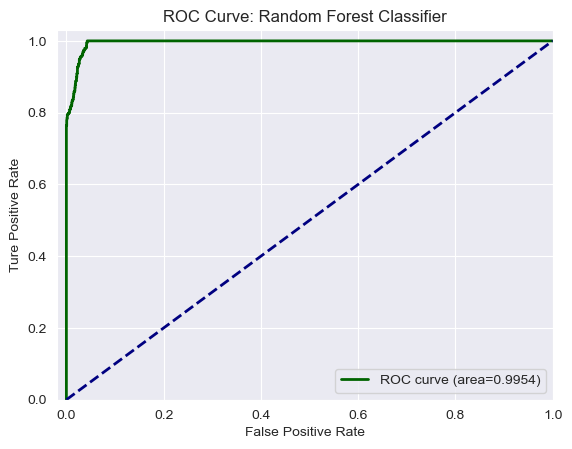

In [56]:
plt.figure()
# set line width = 2
lw = 2
plt.plot(rf_fpr, rf_tpr, color='darkgreen', lw=lw, label='ROC curve (area=%0.4f)' % rf_roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('Ture Positive Rate')
plt.title('ROC Curve: Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

#### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix: Random Forest Classifier')

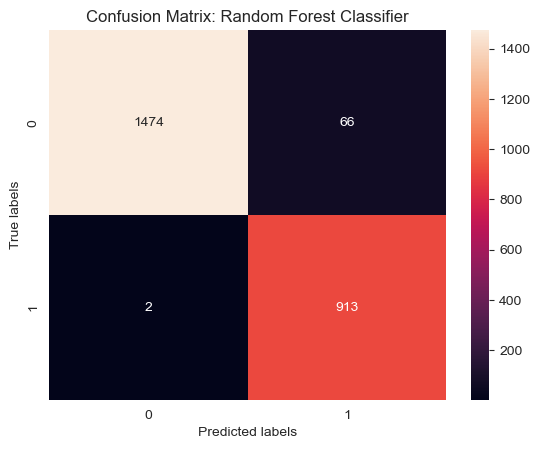

In [57]:
# plot the confusion matrix
cm = confusion_matrix(y_test, rf_y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Random Forest Classifier')

#### Error Analysis: I checked the samples where the Random Forest Classifier failed to predict the true label whether the person default or not default

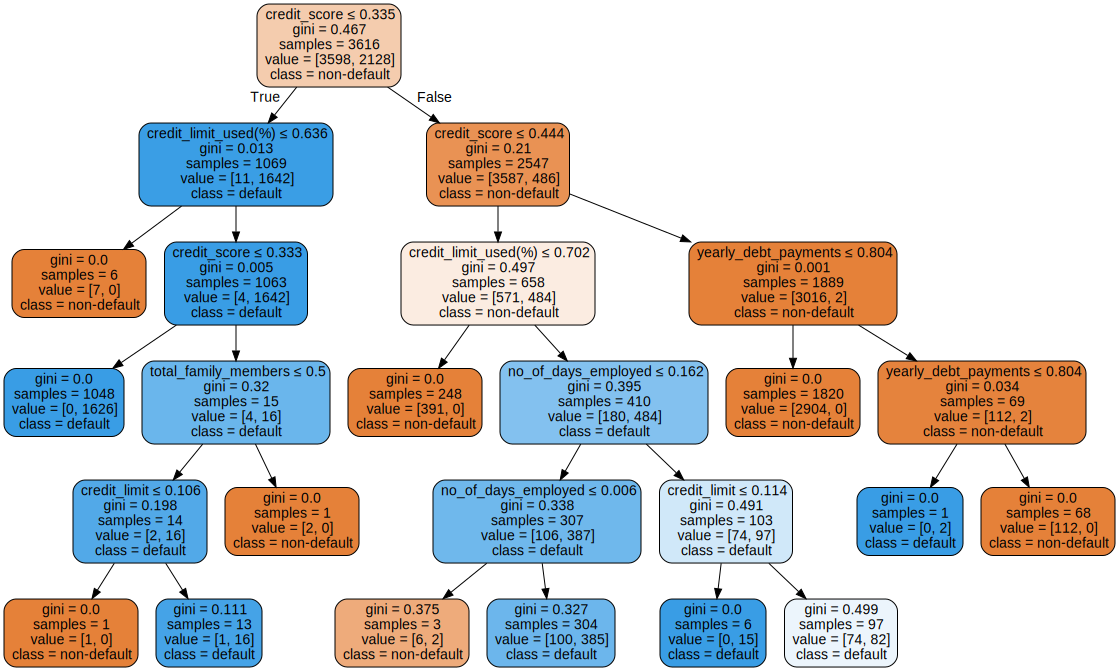

In [58]:
# Plot the first branch from the Random Forest Classification model
dot_data = tree.export_graphviz(rf_clf.estimators_[0], out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['non-default', 'default'],  
                                filled=True, rounded=True,  
                                special_characters=True)   
graph = graphviz.Source(dot_data)  
graph

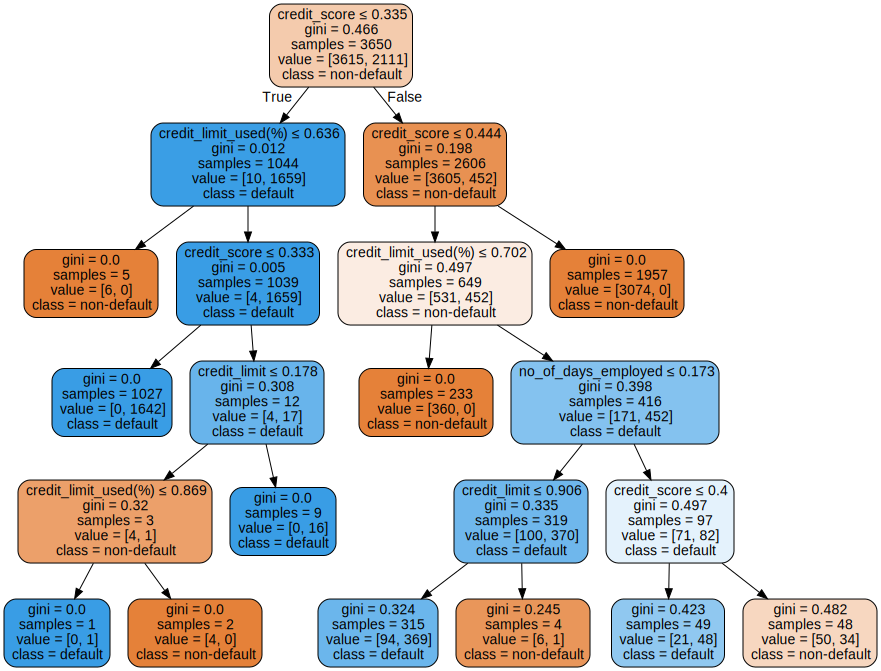

In [59]:
# Plot the second branch from the Random Forest Classification model
dot_data = tree.export_graphviz(rf_clf.estimators_[1], out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['non-default', 'default'],  
                                filled=True, rounded=True,  
                                special_characters=True)   
graph = graphviz.Source(dot_data)  
graph

In [60]:
# concatenate X_test and y_test into a dataframe
rf_test_df = pd.concat([X_test, y_test], axis=1)
rf_test_df['pred_label'] = rf_y_pred_test

# subset the dataframe to show only those which were predicted wrong
# show the first 5 errors
rf_error_df = rf_test_df[rf_test_df['credit_card_default'] != rf_test_df['pred_label']]
rf_error_df.head(10)


age    F    M  Not_Own_Car  Own_Car  Noe_Own_House  Own_House  \
3862  0.18750  1.0  0.0          0.0      1.0            0.0        1.0   
4848  0.12500  0.0  1.0          0.0      1.0            0.0        1.0   
4554  0.90625  1.0  0.0          1.0      0.0            0.0        1.0   
932   0.87500  1.0  0.0          1.0      0.0            1.0        0.0   
2388  0.93750  1.0  0.0          1.0      0.0            0.0        1.0   
4989  0.34375  1.0  0.0          0.0      1.0            0.0        1.0   
3880  0.15625  1.0  0.0          1.0      0.0            0.0        1.0   
4058  0.25000  1.0  0.0          0.0      1.0            1.0        0.0   
6723  1.00000  1.0  0.0          1.0      0.0            0.0        1.0   
2522  0.96875  1.0  0.0          1.0      0.0            0.0        1.0   

      no_of_days_employed  Accountants  Cleaning staff  ...  \
3862             0.228029          0.0             0.0  ...   
4848             0.078016          0.0             0.0  ...   
4554             0.234235          0.0             0.0  ...   
932              0.367180          0.0             0.0  ...   
2388             0.265578          0.0             0.0  ...   
4989             0.017316          0.0             0.0  ...   
3880             0.198672          1.0             0.0  ...   
4058             0.103587          0.0             0.0  ...   
6723             0.549901          0.0             0.0  ...   
2522             0.137165          0.0             0.0  ...   

      Waiters/barmen staff  total_family_members  Not_Migrant_Worker  \
3862                   0.0                  0.50                 0.0   
4848                   0.0                  0.25                 0.0   
4554                   0.0                  0.25                 1.0   
932                    0.0                  0.00                 1.0   
2388                   0.0                  0.25                 1.0   
4989                   0.0                  0.00                 0.0   
3880                   0.0                  0.25                 1.0   
4058                   0.0                  0.25                 1.0   
6723                   0.0                  0.25                 1.0   
2522                   0.0                  0.25                 1.0   

      Migrant_Worker  yearly_debt_payments  credit_limit  \
3862             1.0              0.225103      0.124637   
4848             1.0              0.495039      0.336125   
4554             0.0              0.538310      0.854252   
932              0.0              0.614100      0.377495   
2388             0.0              0.446273      0.214460   
4989             1.0              0.575963      0.484397   
3880             0.0              0.133950      0.357999   
4058             0.0              0.105187      0.725845   
6723             0.0              0.805020      0.692199   
2522             0.0              0.074383      0.307801   

      credit_limit_used(%)  credit_score  credit_card_default  pred_label  
3862              0.888889      0.347439                    0           1  
4848              0.717172      0.427617                    0           1  
4554              0.797980      0.389755                    0           1  
932               0.969697      0.425390                    0           1  
2388              0.979798      0.338530                    0           1  
4989              1.000000      0.409800                    0           1  
3880              0.747475      0.443207                    0           1  
4058              0.838384      0.403118                    0           1  
6723              0.878788      0.376392                    1           0  
2522              0.959596      0.369710                    0           1  

[10 rows x 34 columns]

In [61]:
# the size of errors
rf_error_df.shape

(68, 34)

In [62]:
# find top 10 feature importances
importances = rf_clf.feature_importances_
results_dt = pd.DataFrame({'feature': rf_clf.feature_names_in_, 'importance': importances})
results_dt = results_dt.sort_values('importance', ascending = False)
print(results_dt.head(10))

                 feature  importance
31          credit_score    0.812535
30  credit_limit_used(%)    0.174776
7    no_of_days_employed    0.004917
28  yearly_debt_payments    0.004896
29          credit_limit    0.001567
0                    age    0.000349
2                      M    0.000180
1                      F    0.000104
23               Unknown    0.000084
25  total_family_members    0.000083


Text(0.5, 1.0, 'True prediction credit_limit_used(%)')

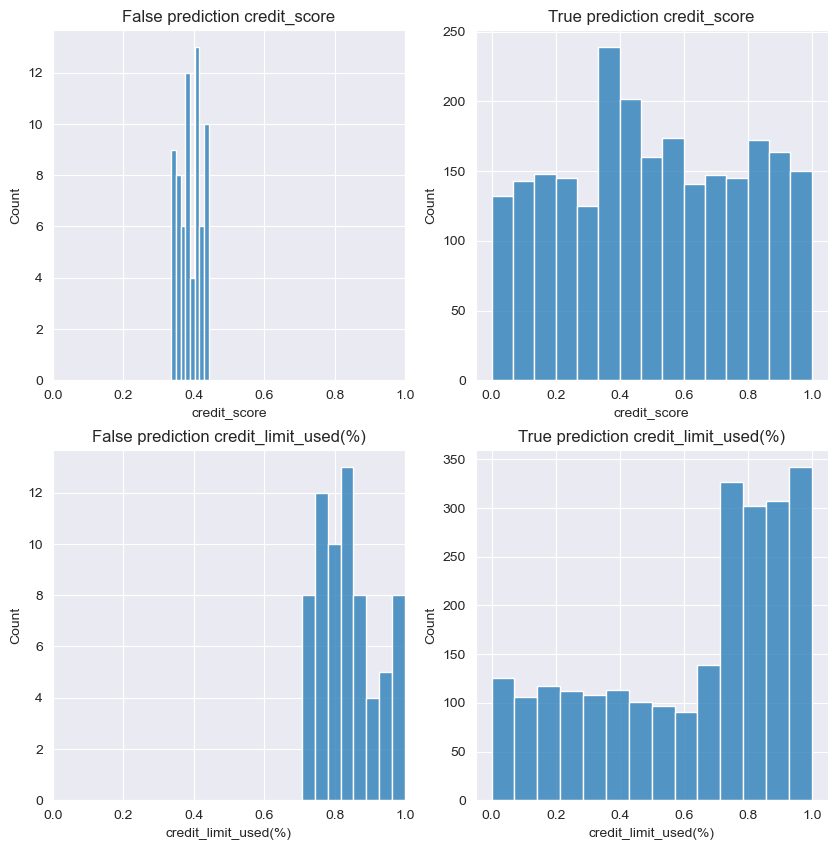

In [63]:
# check the distribution of the top 2 feature importances
# "credit_card_default" and 'Default_In_Last_6months' in both true and false prediction

# create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

rf_true_df = rf_test_df[rf_test_df['credit_card_default'] == rf_test_df['pred_label']]

# draw histogram to check outliers for column "credit_card_default" in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(rf_error_df['credit_score'], ax=axs[0, 0])
axs[0, 0].set_title('False prediction credit_score')
axs[0,0].set_xlim(0,1)

# draw histogram to check outliers for column "credit_card_default" in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(rf_true_df['credit_score'], ax=axs[0, 1])
axs[0, 1].set_title('True prediction credit_score')

# draw histogram to check outliers for column 'credit_limit_used(%)' in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(rf_error_df['credit_limit_used(%)'], ax=axs[1, 0])
axs[1, 0].set_title('False prediction credit_limit_used(%)')
axs[1,0].set_xlim(0,1)

# draw histogram to check outliers for column 'credit_limit_used(%)' in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(rf_true_df['credit_limit_used(%)'], ax=axs[1, 1])
axs[1, 1].set_title('True prediction credit_limit_used(%)')

Text(0.5, 1.0, 'True prediction yearly_debt_payments')

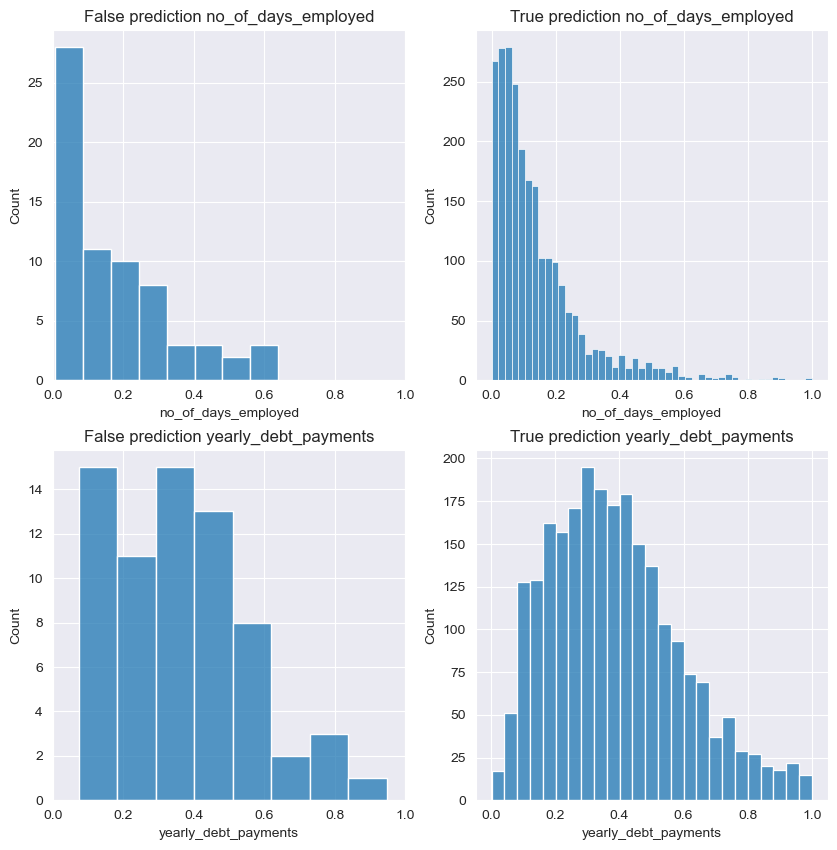

In [64]:
# check the distribution of the top 3 and 4 feature importances
# "credit_card_default" and 'Default_In_Last_6months' in both true and false prediction

# create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

rf_true_df = rf_test_df[rf_test_df['credit_card_default'] == rf_test_df['pred_label']]

# draw histogram to check outliers for column "credit_card_default" in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(rf_error_df['no_of_days_employed'], ax=axs[0, 0])
axs[0, 0].set_title('False prediction no_of_days_employed')
axs[0,0].set_xlim(0,1)

# draw histogram to check outliers for column "credit_card_default" in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(rf_true_df['no_of_days_employed'], ax=axs[0, 1])
axs[0, 1].set_title('True prediction no_of_days_employed')

# draw histogram to check outliers for column 'yearly_debt_payments' in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(rf_error_df['yearly_debt_payments'], ax=axs[1, 0])
axs[1, 0].set_title('False prediction yearly_debt_payments')
axs[1,0].set_xlim(0,1)

# draw histogram to check outliers for column 'yearly_debt_payments' in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(rf_true_df['yearly_debt_payments'], ax=axs[1, 1])
axs[1, 1].set_title('True prediction yearly_debt_payments')

**[FW: Interpret model performance]** My first model is the **Random Forest Classifier model** with the best combination from GridSearchCV.

- The **classification report** and **AUC score** show very good performance of this model with a 0.98 for the class 0 and 0.96 for the class 1, especially for the AUC score which refers to a very high TPR that these two classes can be nearly perfectly separated. According to classfication report, it's clear that the prediction on the class 0 is more accurate than the prediction on the class 1. The **Confusion Matrix** also proves that there are more true positive than true negative. But at the same time, this Random Forest Classifier almost predicted all class '1' correctly with only 2 wrong predictions on the class '1' while it has more wrong predictions on the class '0' with 66 wrong predictions. 


- The **top 10 feature importances** give some insights on how the model works. The top 4 features are respectively 'credit_score', 'credit_limit_used(%)', 'no_of_days_employed' and 'yearly_debt_payments', which are also reflected in the first and second trees from the random forest classifier that I plotted above. I found that these 4 features are dominated in making the decision to split the binary classes in the graphs. It makes sense that these 4 features are the four most important ones since they each have strong correlations with the target variable. For example, if a customer's credit score is very low, he/she already used credit limit a lot, and the cutomer was only employed for a few times and hasn't paid his/her debt much, then this customer will be very possibly predicted as someone who will default in the future. Compared to the magnitude of other top feature importances, the importance of 'credit score' seems very high that may due to the collinearity between 'credit score' and other feature variables and put larger weight to 'credit score' which may finally lead to overfitting issues.


- For **error analysis**, by comparing each of the top 4 features' distributions with classes predicted wrong and with classes predicted correctly. I figured out the error may come from the top two features which are credit_score', 'credit_limit_used(%)' since both distribution with class predicted wrong looks very different from the distributions with class predicted correctly. It's clear that when 'credit score' is ambiguous, which means neither too high nor too low, and when 'credit_limit_used(%)' is very high, which means the customers already used credit limit a lot, the Random Forest Classifier tends to predict the two classes wrong. Since 'credit score' is such important according to the features importance and many splitting decisions were depended on this feature, with the ambiguity of the customer's credit score, thus the model made the wrong predictions. The feature 'credit_limit_used(%)' may give the model a strong indication that whether customer will default or not. So with the distribution of this feature is skewed to the right, the model tends to predict customers with high 'credit_limit_used(%)' as people who will most likely default in the future, which explains why there are 66 customers who should be in the class '0' but predicted to be in the class '1'.

#### 4.12 Model Training and Model Evaluation: Logistic Regression Classification

In [65]:
# Train the Logistic Regression Classification model using best parameters

log_clf = LogisticRegression(random_state=42, max_iter=1000,
                            C=0.5, fit_intercept=True,
                            penalty='l1',
                            solver='liblinear')

log_clf.fit(X_train,y_train)


LogisticRegression(C=0.5, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [66]:
# make predictions on testing data
log_y_pred_test = log_clf.predict(X_test)
# check the predicted probabilties on each data set
log_y_predprob_test = log_clf.predict_proba(X_test)

#### Classification Report

In [67]:
print(classification_report(y_test, log_y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1540
           1       0.94      0.95      0.95       915

    accuracy                           0.96      2455
   macro avg       0.96      0.96      0.96      2455
weighted avg       0.96      0.96      0.96      2455



#### ROC Curve and AUC Curve

In [68]:
log_fpr, log_tpr, log_thresholds = roc_curve(y_true = y_test, y_score = log_y_predprob_test[:, 1], pos_label=1)
log_roc_auc = auc(log_fpr, log_tpr)

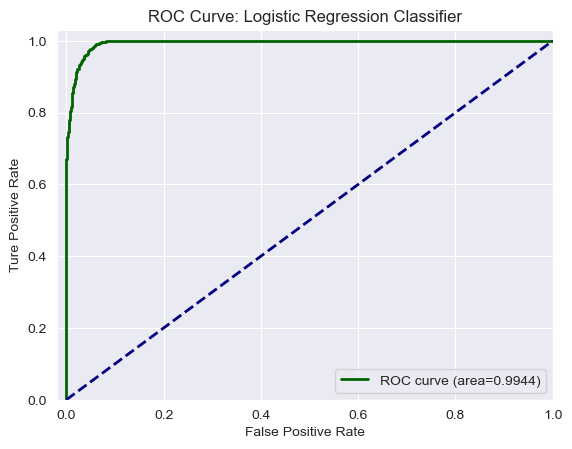

In [69]:
plt.figure()
# set line width = 2
lw = 2
plt.plot(log_fpr, log_tpr, color='darkgreen', lw=lw, label='ROC curve (area=%0.4f)' % log_roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('Ture Positive Rate')
plt.title('ROC Curve: Logistic Regression Classifier')
plt.legend(loc='lower right')
plt.show()

#### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix: Logistic Regression Classifier')

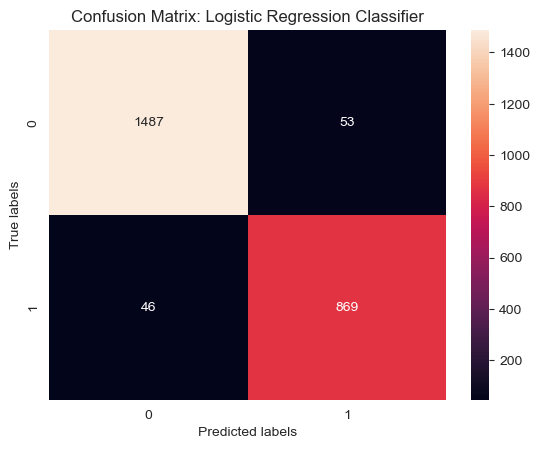

In [70]:
# plot the confusion matrix
cm = confusion_matrix(y_test, log_y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Logistic Regression Classifier')

#### Top Features:

In [71]:
# convert a list of list to a single list
coef_list = [coef for sublist in log_clf.coef_ for coef in sublist]

In [72]:
log_feature_coef = {word: float("%0.3f" % coef) for word, coef in zip(X_train.columns, coef_list)}

In [73]:
# descending (reverse=True) order
# sort the coefficient values

print("Top Positive Features:")
sorted(log_feature_coef.items(), key=lambda x:x[1], reverse=True)[:10]

Top Positive Features:


[('credit_limit_used(%)', 8.487),
 ('Cooking staff', 0.905),
 ('Drivers', 0.294),
 ('Laborers', 0.225),
 ('M', 0.222),
 ('Migrant_Worker', 0.169),
 ('Not_Own_Car', 0.148),
 ('Waiters/barmen staff', 0.077),
 ('Sales staff', 0.033),
 ('yearly_debt_payments', 0.024)]

In [74]:
# ascending (reverse=False)
print("Top Negative Features:")
sorted(log_feature_coef.items(), key=lambda x:x[1], reverse=False)[:10]

Top Negative Features:


[('credit_score', -24.463),
 ('no_of_days_employed', -1.892),
 ('total_family_members', -0.207),
 ('Unknown', -0.129),
 ('Core staff', -0.008),
 ('age', 0.0),
 ('F', 0.0),
 ('Own_Car', 0.0),
 ('Noe_Own_House', 0.0),
 ('Own_House', 0.0)]

#### Error Analysis: I checked the samples where the Random Forest Classifier failed to predict the true label whether the customer will default or not default

In [75]:
# concatenate X_test and y_test into a dataframe
log_test_df = pd.concat([X_test, y_test], axis=1)
log_test_df['pred_label'] = log_y_pred_test

# subset the dataframe to show only those which were predicted wrong
# show the first 5 errors
log_error_df = log_test_df[log_test_df['credit_card_default'] != log_test_df['pred_label']]
log_error_df.head()


age    F    M  Not_Own_Car  Own_Car  Noe_Own_House  Own_House  \
3862  0.18750  1.0  0.0          0.0      1.0            0.0        1.0   
6629  0.31250  1.0  0.0          1.0      0.0            0.0        1.0   
5457  0.09375  1.0  0.0          0.0      1.0            0.0        1.0   
5365  0.87500  0.0  1.0          0.0      1.0            1.0        0.0   
7011  0.43750  0.0  1.0          0.0      1.0            0.0        1.0   

      no_of_days_employed  Accountants  Cleaning staff  ...  \
3862             0.228029          0.0             0.0  ...   
6629             0.396288          0.0             0.0  ...   
5457             0.072058          0.0             0.0  ...   
5365             0.216112          0.0             0.0  ...   
7011             0.130586          0.0             0.0  ...   

      Waiters/barmen staff  total_family_members  Not_Migrant_Worker  \
3862                   0.0                  0.50                 0.0   
6629                   0.0                  0.00                 1.0   
5457                   0.0                  0.50                 1.0   
5365                   0.0                  0.50                 1.0   
7011                   0.0                  0.25                 0.0   

      Migrant_Worker  yearly_debt_payments  credit_limit  \
3862             1.0              0.225103      0.124637   
6629             0.0              0.458249      0.267067   
5457             0.0              0.447975      0.158535   
5365             0.0              0.449706      0.268596   
7011             1.0              0.395895      0.161471   

      credit_limit_used(%)  credit_score  credit_card_default  pred_label  
3862              0.888889      0.347439                    0           1  
6629              0.858586      0.429844                    1           0  
5457              0.787879      0.416481                    1           0  
5365              0.818182      0.443207                    1           0  
7011              0.747475      0.423163                    1           0  

[5 rows x 34 columns]

In [76]:
# the size of errors
log_error_df.shape

(99, 34)

Text(0.5, 1.0, 'True prediction Cooking staff')

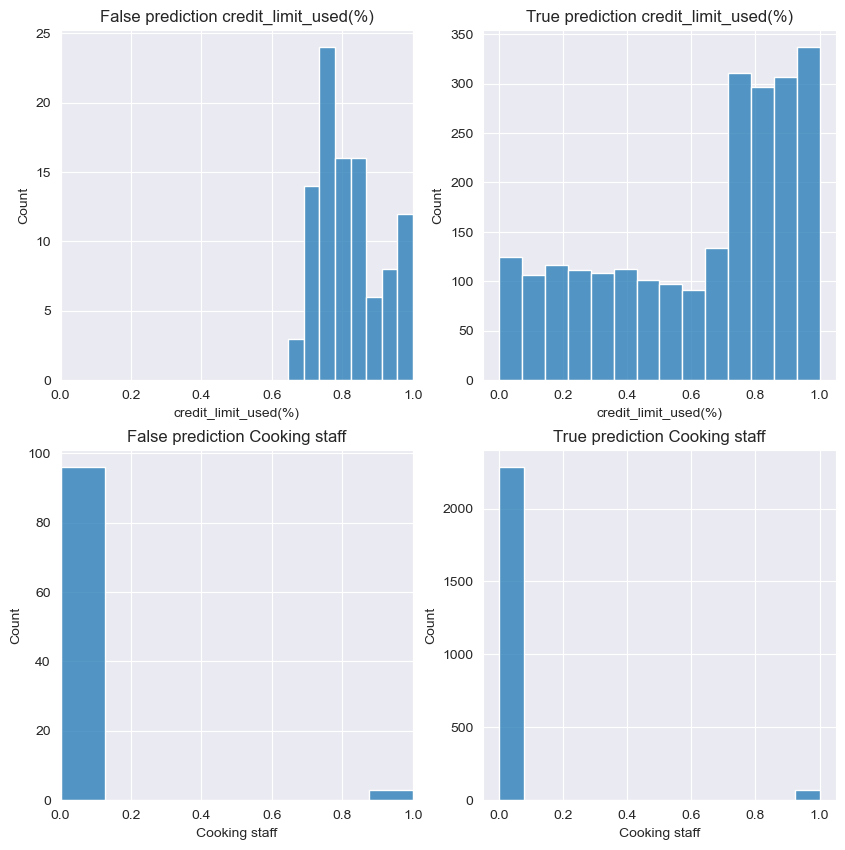

In [77]:
# check the distribution of the top 2 positive features
# "credit_card_default" and 'Default_In_Last_6months' in both true and false prediction

# create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

log_true_df = log_test_df[log_test_df['credit_card_default'] == log_test_df['pred_label']]

# draw histogram to check outliers for column "credit_limit_used(%)" in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(log_error_df['credit_limit_used(%)'], ax=axs[0, 0])
axs[0, 0].set_title('False prediction credit_limit_used(%)')
axs[0,0].set_xlim(0,1)

# draw histogram to check outliers for column "credit_limit_used(%)" in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(log_true_df['credit_limit_used(%)'], ax=axs[0, 1])
axs[0, 1].set_title('True prediction credit_limit_used(%)')

# draw histogram to check outliers for column 'Cooking staff' in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(log_error_df['Cooking staff'], ax=axs[1, 0])
axs[1, 0].set_title('False prediction Cooking staff')
axs[1,0].set_xlim(0,1)

# draw histogram to check outliers for column 'Cooking staff' in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(log_true_df['Cooking staff'], ax=axs[1, 1])
axs[1, 1].set_title('True prediction Cooking staff')

Text(0.5, 1.0, 'True prediction no_of_days_employed')

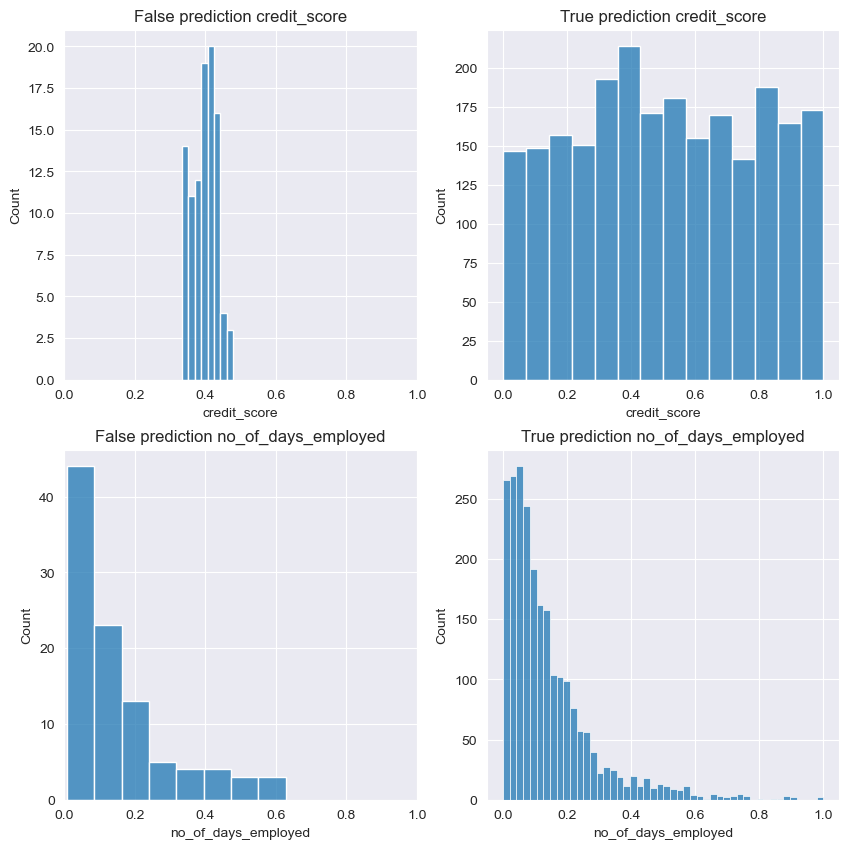

In [78]:
# check the distribution of the top 2 negative features
# 'credit_score' and 'no_of_days_employed' in both true and false prediction

# create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

log_true_df = log_test_df[log_test_df['credit_card_default'] == log_test_df['pred_label']]

# draw histogram to check outliers for column "credit_score" in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(log_error_df['credit_score'], ax=axs[0, 0])
axs[0, 0].set_title('False prediction credit_score')
axs[0,0].set_xlim(0,1)

# draw histogram to check outliers for column "credit_score" in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(log_true_df['credit_score'], ax=axs[0, 1])
axs[0, 1].set_title('True prediction credit_score')

# draw histogram to check outliers for column 'no_of_days_employed' in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(log_error_df['no_of_days_employed'], ax=axs[1, 0])
axs[1, 0].set_title('False prediction no_of_days_employed')
axs[1,0].set_xlim(0,1)

# draw histogram to check outliers for column 'no_of_days_employed' in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(log_true_df['no_of_days_employed'], ax=axs[1, 1])
axs[1, 1].set_title('True prediction no_of_days_employed')

**[FW: Interpret model performance]** My second model is the **Logistic Regression Classifier model** with the best combination from GridSearchCV.

- The **classification report** and **AUC score** show very good performance of this model, especially for the AUC score which refers to a very high TPR that these two classes are nearly perfectly separated. From the classification report, I also found that the accuracy of predicting the class '0' is slightly higher than the accuracy of predicting 1, which may be caused by the imperfect balance between class '0' and '1' in both the training and testing set.


- The **top and negative features** give some insights on how the model works. For example, the top 1 positive features like 'credit_limit_used(%)' that have the strongest positive correlations with the target variable of whether there will be credit card default or not makes sense because with more credit limit being used, it's very likely to predict that the customer is going to default. Likewise the top 2 negative features like 'no_of_days_employed' makes sense that with more days being hired, the customer is very unlikey to default. However, although the top 1 negative feature 'credit_score' does seem reasonable and it's a probably the strongest indicator to predict if the customer will default or not, compared to the magnitude of the top 2 and 3 negative features' coefficients, the coefficient of 'credit score' is extremely high that may due to the collinearity between 'credit score' and 'credit_limit_used(%)' and put larger weight to 'credit score' which may finally lead to overfitting issues. It may also explain why the cofficient of 'credit_limit_used(%)' has a higher magnitude compared to other coefficients of top positive features.


- For **error analysis**, **Confusion Matrix** actually did a good job in showing there are slightly more errors of predicting the class 1 than errors of predicting the class 0, which may be caused by my imperfect balanced training and testing sets. When I compare the distribution of top 2 positive and top 2 negative features with classes predicted correctly and with classes predicted wrong, I identified that the error is from bias towards 'credit_limit_used(%)' and ambiguity of 'credit_score'. For example, in all errors, the distribtution of 'credit_limit_used(%)' is skewed right, which reflects that if a customer has high credit_limit_used(%), then the customer will be most likely predicted as someone who will default in the future no matter what if it's true or not. Also, if the customer's credit score is not very low or very high, the ambiguity makes the model hard to make sure if he/she will default, which lead to the errors. The distribution of 'no_of_days_employed' and the distribution of 'Cooking staff' in true samples and wrong samples look very similar so it's indicated that these two features may not be the factor that caused the errors. 


- **[Compare rf with log]** However, compared to the Random Forest Classifier, the performance of Logistic Regression Classifier is slightly worse than the Random Forest Classifier. It may be because the Logistic Regression Classifier mostly handle linear relationships while Random Forest Classifier can handle both linear and nonlinear relationships. There may be both non-linear and linear relationship in my dataset, which explains why in this dataset, Random Forest Classifier can perform better. Also, even though I removed features that can cause multilinearity issues, there's still slight multilinearity, for example, between 'credit_score' and 'credit_limit_used'. Random Forest Classifier, in this case, can reduce the correlation between features because it selects features randomly for each split of each tree. 

#### 4.13 Model Training and Model Evaluation: Support vector machine (SVM)

In [79]:
# Train the Support vector machine (SVM) Classification model using best parameters

svm_clf = SVC(random_state=42, C=2.0, gamma='scale', kernel='linear', probability=True)

svm_clf.fit(X_train,y_train)


SVC(C=2.0, kernel='linear', probability=True, random_state=42)

In [80]:
# make predictions on testing data
svm_y_pred_test = svm_clf.predict(X_test)
# check the predicted probabilties on each data set
svm_y_predprob_test = svm_clf.predict_proba(X_test)

#### Classification Report¶

In [81]:
print(classification_report(y_test, svm_y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1540
           1       0.94      0.96      0.95       915

    accuracy                           0.96      2455
   macro avg       0.95      0.96      0.96      2455
weighted avg       0.96      0.96      0.96      2455



#### ROC Curve and AUC Curve

In [82]:
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_true = y_test, y_score = svm_y_predprob_test[:, 1], pos_label=1)
svm_roc_auc = auc(svm_fpr, svm_tpr)

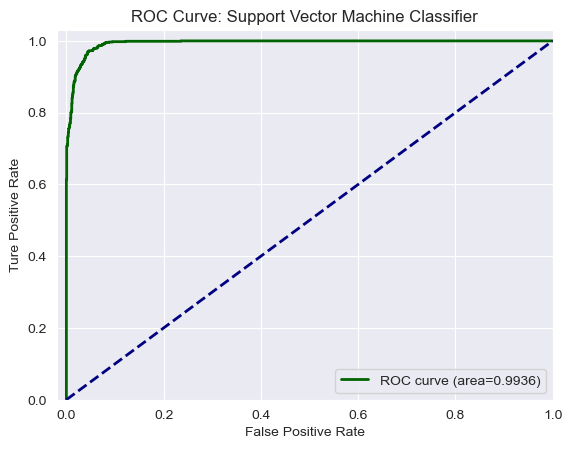

In [83]:
plt.figure()
# set line width = 2
lw = 2
plt.plot(svm_fpr, svm_tpr, color='darkgreen', lw=lw, label='ROC curve (area=%0.4f)' % svm_roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('Ture Positive Rate')
plt.title('ROC Curve: Support Vector Machine Classifier')
plt.legend(loc='lower right')
plt.show()

#### Confusion Matrix¶

Text(0.5, 1.0, 'Confusion Matrix: Support Vector Machine Classifier')

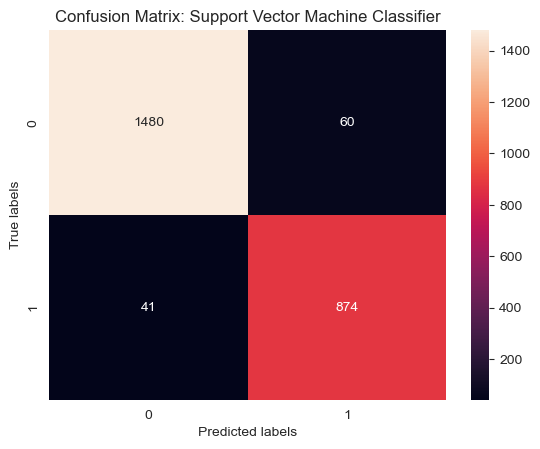

In [84]:
# plot the confusion matrix
cm = confusion_matrix(y_test, svm_y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Support Vector Machine Classifier')

#### Top Features:

In [85]:
# convert a list of list to a single list
coef_list = [coef for sublist in svm_clf.coef_ for coef in sublist]

svm_feature_coef = {word: float("%0.3f" % coef) for word, coef in zip(X_train.columns, coef_list)}

In [86]:
# descending (reverse=True) order
# sort the coefficient values

print("Top Positive Features:")
sorted(svm_feature_coef.items(), key=lambda x:x[1], reverse=True)[:10]

Top Positive Features:


[('credit_limit_used(%)', 5.214),
 ('Cooking staff', 0.699),
 ('Waiters/barmen staff', 0.575),
 ('Drivers', 0.496),
 ('Cleaning staff', 0.355),
 ('yearly_debt_payments', 0.316),
 ('Laborers', 0.291),
 ('Security staff', 0.282),
 ('HR staff', 0.123),
 ('High skill tech staff', 0.123)]

In [87]:
# ascending (reverse=False)
print("Top Negative Features:")
sorted(svm_feature_coef.items(), key=lambda x:x[1], reverse=False)[:10]

Top Negative Features:


[('credit_score', -13.098),
 ('Secretaries', -1.697),
 ('no_of_days_employed', -1.506),
 ('Realty agents', -0.609),
 ('Private service staff', -0.586),
 ('credit_limit', -0.49),
 ('total_family_members', -0.2),
 ('Unknown', -0.081),
 ('Medicine staff', -0.064),
 ('Not_Migrant_Worker', -0.06)]

#### Error Analysis: I checked the samples where the Random Forest Classifier failed to predict the true label whether the person default or not default¶

In [88]:
# concatenate X_test and y_test into a dataframe
svm_test_df = pd.concat([X_test, y_test], axis=1)
svm_test_df['pred_label'] = svm_y_pred_test

# subset the dataframe to show only those which were predicted wrong
# show the first 5 errors
svm_error_df = svm_test_df[svm_test_df['credit_card_default'] != svm_test_df['pred_label']]
svm_error_df.head()


age    F    M  Not_Own_Car  Own_Car  Noe_Own_House  Own_House  \
3862  0.18750  1.0  0.0          0.0      1.0            0.0        1.0   
1480  0.93750  1.0  0.0          1.0      0.0            0.0        1.0   
6629  0.31250  1.0  0.0          1.0      0.0            0.0        1.0   
5457  0.09375  1.0  0.0          0.0      1.0            0.0        1.0   
5365  0.87500  0.0  1.0          0.0      1.0            1.0        0.0   

      no_of_days_employed  Accountants  Cleaning staff  ...  \
3862             0.228029          0.0             0.0  ...   
1480             0.056293          0.0             0.0  ...   
6629             0.396288          0.0             0.0  ...   
5457             0.072058          0.0             0.0  ...   
5365             0.216112          0.0             0.0  ...   

      Waiters/barmen staff  total_family_members  Not_Migrant_Worker  \
3862                   0.0                   0.5                 0.0   
1480                   0.0                   0.0                 1.0   
6629                   0.0                   0.0                 1.0   
5457                   0.0                   0.5                 1.0   
5365                   0.0                   0.5                 1.0   

      Migrant_Worker  yearly_debt_payments  credit_limit  \
3862             1.0              0.225103      0.124637   
1480             0.0              0.314398      0.371022   
6629             0.0              0.458249      0.267067   
5457             0.0              0.447975      0.158535   
5365             0.0              0.449706      0.268596   

      credit_limit_used(%)  credit_score  credit_card_default  pred_label  
3862              0.888889      0.347439                    0           1  
1480              0.898990      0.454343                    0           1  
6629              0.858586      0.429844                    1           0  
5457              0.787879      0.416481                    1           0  
5365              0.818182      0.443207                    1           0  

[5 rows x 34 columns]

In [89]:
# the size of errors
svm_error_df.shape

(101, 34)

Text(0.5, 1.0, 'True prediction Cooking staff')

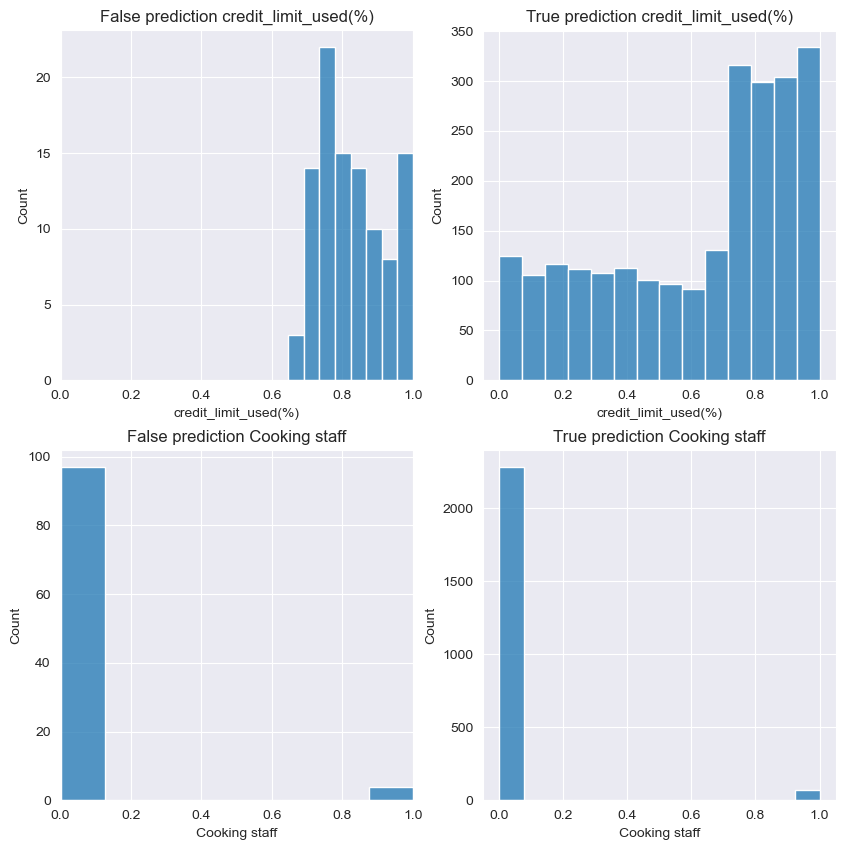

In [90]:
# check the distribution of the top 2 positive features
# "credit_card_default" and 'Default_In_Last_6months' in both true and false prediction

# create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

svm_true_df = svm_test_df[svm_test_df['credit_card_default'] == svm_test_df['pred_label']]

# draw histogram to check outliers for column "credit_limit_used(%)" in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(svm_error_df['credit_limit_used(%)'], ax=axs[0, 0])
axs[0, 0].set_title('False prediction credit_limit_used(%)')
axs[0,0].set_xlim(0,1)

# draw histogram to check outliers for column "credit_limit_used(%)" in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(svm_true_df['credit_limit_used(%)'], ax=axs[0, 1])
axs[0, 1].set_title('True prediction credit_limit_used(%)')

# draw histogram to check outliers for column 'Cooking staff' in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(svm_error_df['Cooking staff'], ax=axs[1, 0])
axs[1, 0].set_title('False prediction Cooking staff')
axs[1,0].set_xlim(0,1)

# draw histogram to check outliers for column 'Cooking staff' in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(svm_true_df['Cooking staff'], ax=axs[1, 1])
axs[1, 1].set_title('True prediction Cooking staff')

Text(0.5, 1.0, 'True prediction Secretaries')

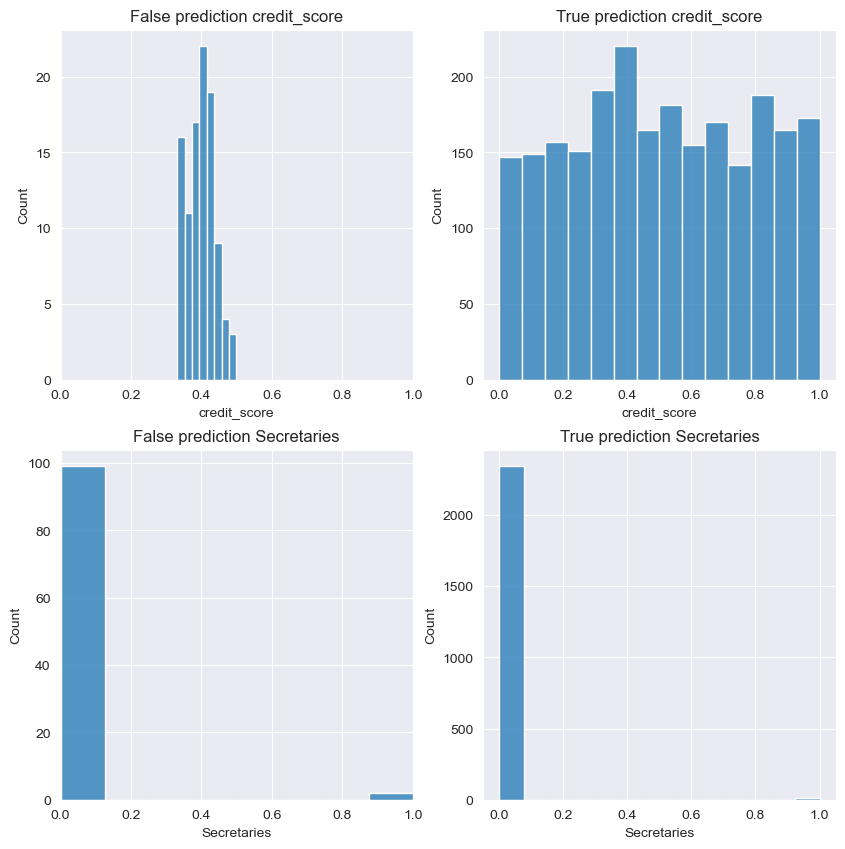

In [91]:
# check the distribution of the top 2 negative features
# 'credit_score' and 'no_of_days_employed' in both true and false prediction

# create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

svm_true_df = svm_test_df[svm_test_df['credit_card_default'] == svm_test_df['pred_label']]

# draw histogram to check outliers for column "credit_score" in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(svm_error_df['credit_score'], ax=axs[0, 0])
axs[0, 0].set_title('False prediction credit_score')
axs[0,0].set_xlim(0,1)

# draw histogram to check outliers for column "credit_score" in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(svm_true_df['credit_score'], ax=axs[0, 1])
axs[0, 1].set_title('True prediction credit_score')

# draw histogram to check outliers for column 'Secretaries' in errors
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(svm_error_df['Secretaries'], ax=axs[1, 0])
axs[1, 0].set_title('False prediction Secretaries')
axs[1,0].set_xlim(0,1)

# draw histogram to check outliers for column 'Secretaries' in truths
sns.set_style("darkgrid",{'axes.grid' : True})
sns.histplot(svm_true_df['Secretaries'], ax=axs[1, 1])
axs[1, 1].set_title('True prediction Secretaries')

**[FW: Interpret model performance]** My third model is the **Support Vector Machine Classifier Model** with the best combination from GridSearchCV.

- Both **classification report** and **AUC score** show very good performance of this model, especially for the AUC score which refers to a very high TPR that these two classes are nearly perfectly separated. Similar to the two models above, the classification report also shows that the accuracy of predicting class '0' is slightly higher than the accuracy of predicting the class '1', which again may be caused by the imperfect balance between class '0' and '1' in both the training and testing set.


- The top and negative features give some insights on how the model works. Similar to top features in the Logistic Regression Classifier, the top 2 positive features are still 'credit_limit_used(%)' and 'Cooking staff' and the top 2 negative features are still 'credit_score' and 'Secretaries'. Also similarly, for error analysis, the distribution of top 2 positive and top 2 negative features with classes predicted correctly and with classes predicted wrong is almost the same as the distribution shown in the Logistic Regression Classifier, which means errors of svm classifier may also be caused from bias towards 'credit_limit_used(%)' and ambiguity of 'credit_score'. 


- **[Compare log with svm]** However, different from the Logistic Regression Classifier, the weight/coefficient of each top features is lower, especially for the weight/coefficient of 'credit score'. This may because Logistic Regression Classifier is more prone to overfitting. As explained above, due to some collinearities between 'credit_score' and other variables, when the model is being trained, it tends to overfit the feature 'credit_score', which makes its coefficient has a much more magnitude compared to coefficient of other features. But since SVM isn't that prone to overfitting, the coefficient of 'credit_score' is much lower. Overall, according to the AUC score, and confusion matrix, svm classifier has a poorer performance compared to Logistic Regression Classifier. I think there can be one possible reason: in general, svm classifier is more sensitive to data imbalance than both Logistic Regression Classifier and Random Forest Classifier, because svm classifier applies a decision boundary to maximize the margin between two classes and if the two classes are imbalanced, then there will be bias towards the majority class and the minority class will be underrepresented, which finally leads to the poorer performance for the minority class.

###  5. Evaluation Summary

In [92]:
score_summary = {'Model Type': ['Random Forest Classifier', 'Logistic Regression Classifier', 'Support Vector Machine Classifier'],
                'F1-Score': ['0: 0.98, 1: 0.96', '0: 0.97, 1: 0.95', '0: 0.97, 1: 0.95'],
                'AUC Score': ['0.9954', '0.9944', '0.9936']}
summary = pd.DataFrame(score_summary, index=[1,2,3])
summary


Model Type          F1-Score AUC Score
1           Random Forest Classifier  0: 0.98, 1: 0.96    0.9954
2     Logistic Regression Classifier  0: 0.97, 1: 0.95    0.9944
3  Support Vector Machine Classifier  0: 0.97, 1: 0.95    0.9936

###  6. Conclusion

In total, I built three binary classification models for American Express's Credit Card Default Risk Dataset. The three machine learning models used were a Random Forest Classifier, a Logistic Regression Classifier, and a Support Vector Classifier. The pipelines of my project is in the following:

- **Problem formulation**: I first formulate this project to a Supervised Machine Learning Binary Classification task. 
- **Exploratory data analysis & Data Preprocessing**: I then explored and cleaned the data including dropping columns with unique values, removing missing values, converting data types, removing outliers. Due to the extreme imbalance of the dataset, I also undersample my dataset to make the class '0' and class '1' nearly balanced. Also, I normalized all numerical variables and used one-hot encoding to conduct the feature engineering for categorical variables.
- **Feature Selection & Parameter Tuning & Data Validation**: I split the data into 70% training and 30% testing sets. I then built 3 pipelines and use GridSearchCV to explore the best parameter combinations for each model on the training set. 
- **Model Training & Model Evaluation**: Next, I trained my data using Random Forest Classifier, a Logistic Regression Classifier, and a Support Vector Classifier with the best parameters combination for each model predicted by GridSearchCV. I then evaluated my 3 models' performance on the testing set using 3 strategies including classification report, ROC curve/AUC score, and confusion matrix.
- **Model Explanation & Error Analysis**: Lastly, I checked the top feature importances for Random Forest Classifier and checked features with top coefficients for Logistic Regression Classifier and a Support Vector Classifier to explain how the model works and the model performance. I also conducted error analysis for all three models by presenting examples of where the classifiers make wrong predictions and by pointing out my ideas of where these errors come from and why.

Overall, all three models have good performance with F1-Score all over 95 and AUC Score nearly equal to 100. However, it's worth mentioning that Random Forest Classifier is the best way to go compared to Logistic Regression Classifier and Support Vector Classifier for binary classification of whether the customer will default or not based on my analysis and evaluation above. 


In the future, to improve the model performance, firstly, there should be more data in the training set and I can then make the class '0' and '1' more balanced. Because if there are more data in the training set, after undersampling, there will be still enough date to train the models so that I don't have to make a balance between data size and data imbalance in this project. Secondly, stratergies to avoid multilinearity such as PCA(Principal Component Analysis) should be applied to the feature variables. Although I already tried to make all correlations between each variables under 0.5, there are still some correlations of around 0.4 between variables. To make each variables more independent, I think PCA is necessary to be conducted. Lastly, there should be more predictive features being created or collected. According to the feature importances and the coefficients of features, it's clear that 'credit_score' is predominately the most important indicator to predict whether the customr will default or not. So when credit_score becomes ambiguious (not too high or too low), the model that depend on the feature 'credit_score' a lot fails to make correct predictions. That's why more informative features in the dataset can be very helpful to further improve the model performance.